#Preprocesado de los datos

Para poder entrenar un modelo adecuado para el problema, es necesario preprocesar los datos, manejando politicas de reemplazo para datos faltantes, conversión de columnas de variables cualitativas o de categorías, entre otros ajustes necesarios para obtener un dataset adecuado sobre el cual aplicar una plantilla de modelo adecuada

##Importaciones básicas

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

##Carga y análisis de los datos

###Descarga directa desde Kaggle

In [ ]:
!mkdir /root/.config/kaggle
!mv kaggle.json /root/.config/kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.config/kaggle’: File exists


In [ ]:
!chmod 600 /root/.config/kaggle/kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia
!unzip udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 714MB/s]
Archive:  udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


###Creación del objeto dataframe

In [ ]:
df = pd.read_csv("train.csv")

###Exploración y análisis

Un primer acercamiento es evaluar el tipo de datos de cada una de las columnas que se tienen para identificar aquellas que requieren una conversión por tratarse de variables categoricas o cualitativas

In [ ]:
for column in df.columns:
    print ("%20s"%column, df[column].dtype)

                  ID int64
             PERIODO int64
 ESTU_PRGM_ACADEMICO object
ESTU_PRGM_DEPARTAMENTO object
ESTU_VALORMATRICULAUNIVERSIDAD object
ESTU_HORASSEMANATRABAJA object
FAMI_ESTRATOVIVIENDA object
  FAMI_TIENEINTERNET object
 FAMI_EDUCACIONPADRE object
  FAMI_TIENELAVADORA object
 FAMI_TIENEAUTOMOVIL object
ESTU_PRIVADO_LIBERTAD object
ESTU_PAGOMATRICULAPROPIO object
FAMI_TIENECOMPUTADOR object
FAMI_TIENEINTERNET.1 object
 FAMI_EDUCACIONMADRE object
  RENDIMIENTO_GLOBAL object
              coef_1 float64
              coef_2 float64
              coef_3 float64
              coef_4 float64


####Variable respuesta

Es fundamental distinguir el tipo y valores de la variable respuesta para poder entender el tipo de problema al cual nos estamos enfrentando. Para este proyecto, el objetivo es predecir el rendimiento que obtienen los estudiantes en sus pruebas Saber Pro, y tal como se describe, esta es una variable cualitativa que se define mediante las siguientes categorías:

* bajo
* medio-bajo
* medio-alto
* alto.

Por lo tanto nos enfrentamos ante un problema de clasificación

In [ ]:
null_registers = np.sum(df['RENDIMIENTO_GLOBAL'].isna())
total = df.shape[0]
percentage = np.round(100*null_registers/total,2)
print ("Valores nulos: ", null_registers, "de un total de: ", total,
                   "Representa un porcentaje de: %.2f%%" %percentage)
df['RENDIMIENTO_GLOBAL'].describe()

Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00%


,RENDIMIENTO_GLOBAL
count,692500
unique,4
top,alto
freq,175619


#####Distribución de la variable respuesta

,count
RENDIMIENTO_GLOBAL,
alto,175619
bajo,172987
medio-bajo,172275
medio-alto,171619


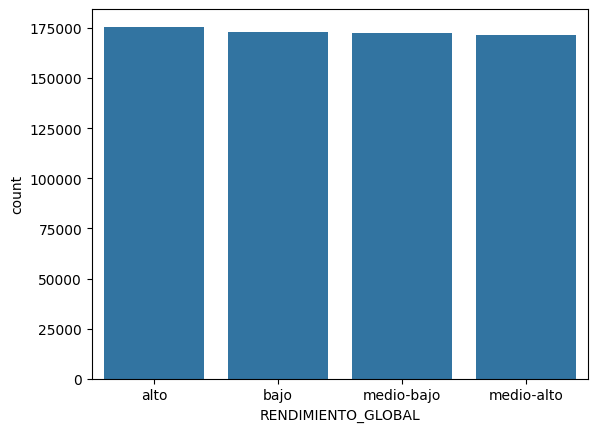

In [ ]:
vc = df['RENDIMIENTO_GLOBAL'].dropna().value_counts()
sns.barplot(vc)
vc

No existe una tendencia especifica en los resultados de las pruebas sino que se observa en general, una distribución uniforme del rendimiento

####Variables cualitativas o categoricas

Las columnas que representan información cualitativa corresponden a la información relacionada con

1. Información socieconómica: En esta podemos agrupar las siguientes propiedades o columnas del dataset:

* FAMI_TIENEINTERNET
* FAMI_TIENELAVADORA
* FAMI_TIENEAUTOMOVIL
* FAMI_TIENECOMPUTADOR
* FAMI_TIENEINTERNET.1 (Repetida)
* FAMI_EDUCACIONPADRE
* FAMI_EDUCACIONMADRE
* FAMI_ESTRATOVIVIENDA

2. Información de instituciones: Información de las instituciones que agrupa las siguientes columnas

* ESTU_PRGM_DEPARTAMENTO

3. Información del estudiante: Para esta categoría se pueden agrupar las siguientes columnas

* ESTU_PRGM_ACADEMICO
* ESTU_PRIVADO_LIBERTAD
* ESTU_PAGOMATRICULAPROPIO


#####Estrato vivienda

En la exploración inicial se comprobó que el estrato de la vivienda es de tipo texto y define categorías ordenadas por lo que se podría convertir en la misma columna

In [ ]:
column = 'FAMI_ESTRATOVIVIENDA'
null_registers = np.sum(df[column].isna())
total = df.shape[0]
percentage = np.round(100*null_registers/total,2)
print ("Valores nulos: ", null_registers, "de un total de: ", total,
                   "Representa un porcentaje de: %.2f%%" %percentage, '\n')

not_null_total = total - null_registers
for resp in df[column].dropna().unique():
  print(resp, df[column].value_counts()[resp], \
        np.round(df[column].value_counts()[resp]/not_null_total*100,2),"%")

df[column].describe()

Valores nulos:  32137 de un total de:  692500 Representa un porcentaje de: 4.64% 

Estrato 3 210685 31.9 %
Estrato 4 65514 9.92 %
Estrato 5 23608 3.58 %
Estrato 2 232671 35.23 %
Estrato 1 111991 16.96 %
Estrato 6 12605 1.91 %
Sin Estrato 3289 0.5 %


,FAMI_ESTRATOVIVIENDA
count,660363
unique,7
top,Estrato 2
freq,232671


Los valores sin estrato podrian adicionarse como una categoría minima o considerarse como un registro nulo

#####Variables de acceso: Recursos

En la exploración inicial realizada comprobamos que existen dos columnas repetidas para representar si las familias tienen acceso a internet o no. En este caso basta con considerar solo una de estas en este caso eliminamos del dataframe la columna FAMI_TIENEINTERNET.1. Además se espera que todas las columnas que evaluan el acceso a cierto recurso tenga únicamente dos valores posibles (Si o no)

In [ ]:
df = df.drop(columns=['FAMI_TIENEINTERNET.1'])

In [ ]:
df_resources = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA',
                   'FAMI_TIENEAUTOMOVIL','FAMI_TIENECOMPUTADOR']

for column in df_resources:
  null_registers = np.sum(df[column].isna())
  total = df.shape[0]
  percentage = np.round(100*null_registers/total,2)
  print(column)
  print ("Valores nulos: ", null_registers, "de un total de: ", total,
                    "Representa un porcentaje de: %.2f%%" %percentage, '\n')

  not_null_total = total - null_registers
  for resp in df[column].dropna().unique():
    print(resp, df[column].value_counts()[resp], \
          np.round(df[column].value_counts()[resp]/not_null_total*100,2),"%")

  print('\n', df[column].describe(), '\n')

FAMI_TIENEINTERNET
Valores nulos:  26629 de un total de:  692500 Representa un porcentaje de: 3.85% 

Si 592514 88.98 %
No 73357 11.02 %

 count     665871
unique         2
top           Si
freq      592514
Name: FAMI_TIENEINTERNET, dtype: object 

FAMI_TIENELAVADORA
Valores nulos:  39773 de un total de:  692500 Representa un porcentaje de: 5.74% 

Si 563390 86.31 %
No 89337 13.69 %

 count     652727
unique         2
top           Si
freq      563390
Name: FAMI_TIENELAVADORA, dtype: object 

FAMI_TIENEAUTOMOVIL
Valores nulos:  43623 de un total de:  692500 Representa un porcentaje de: 6.30% 

Si 236271 36.41 %
No 412606 63.59 %

 count     648877
unique         2
top           No
freq      412606
Name: FAMI_TIENEAUTOMOVIL, dtype: object 

FAMI_TIENECOMPUTADOR
Valores nulos:  38103 de un total de:  692500 Representa un porcentaje de: 5.50% 

Si 597670 91.33 %
No 56727 8.67 %

 count     654397
unique         2
top           Si
freq      597670
Name: FAMI_TIENECOMPUTADOR, dtype: object 

Cómo era de esperar solo existen dos valores posibles para este tipo de variables (Si o no) y una conversión one-hot genera dos columnas nuevas para cada una de ellas. Otra posibilidad es la de cambiar directamente los valores a los enteros "booleanos" 0 o 1

#####Educación de padres

Para este par de columnas se espera que se tengan las dos mismas categorías para cada una de las columnas que discriminan los niveles de educación alcanzados por cada padre

In [ ]:
for column in ['FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE']:
  null_registers = np.sum(df[column].isna())
  total = df.shape[0]
  percentage = np.round(100*null_registers/total,2)
  print(column)
  print ("Valores nulos: ", null_registers, "de un total de: ", total,
                    "Representa un porcentaje de: %.2f%%" %percentage, '\n')

  not_null_total = total - null_registers
  for resp in df[column].dropna().unique():
    print(resp, df[column].value_counts()[resp], \
          np.round(df[column].value_counts()[resp]/not_null_total*100,2),"%")

  print('\n', df[column].describe(), '\n')

FAMI_EDUCACIONPADRE
Valores nulos:  23178 de un total de:  692500 Representa un porcentaje de: 3.35% 

Técnica o tecnológica incompleta 22552 3.37 %
Técnica o tecnológica completa 62995 9.41 %
Secundaria (Bachillerato) completa 128289 19.17 %
No sabe 16592 2.48 %
Primaria completa 55958 8.36 %
Educación profesional completa 83117 12.42 %
Educación profesional incompleta 27084 4.05 %
Primaria incompleta 125675 18.78 %
Postgrado 44169 6.6 %
Secundaria (Bachillerato) incompleta 71654 10.71 %
Ninguno 22008 3.29 %
No Aplica 9229 1.38 %

 count                                 669322
unique                                    12
top       Secundaria (Bachillerato) completa
freq                                  128289
Name: FAMI_EDUCACIONPADRE, dtype: object 

FAMI_EDUCACIONMADRE
Valores nulos:  23664 de un total de:  692500 Representa un porcentaje de: 3.42% 

Postgrado 46246 6.91 %
Técnica o tecnológica incompleta 27533 4.12 %
Secundaria (Bachillerato) completa 141744 21.19 %
Primaria complet

Vemos entonces como ambas columnas registran las mismas doce categorías (Ordenadas de menor a mayor nivel) exceptuando las categorías "no informativas":

1. Ninguno
2. Primaria incompleta
3. Primaria completa
4. Secundaria (Bachillerato) incompleta
5. Secundaria (Bachillerato) completa
6. Técnica o tecnológica incompleta
7. Técnica o tecnológica completa
8. Educación profesional incompleta
9. Educación profesional completa
10. Postgrado
11. No sabe
12. No aplica

#####Departamentos

En este caso se espera que la totalidad de valores sean de los 32 distintos departamentos del país. Del análisis exploratorio inicial vimos que esta columna no posee registros nulos

In [ ]:
null_registers = np.sum(df['ESTU_PRGM_DEPARTAMENTO'].isna())
total = df.shape[0]
percentage = np.round(100*null_registers/total,2)
print ("Valores nulos: ", null_registers, "de un total de: ", total,
                   "Representa un porcentaje de: %.2f%%" %percentage, '\n')
df['ESTU_PRGM_DEPARTAMENTO'].describe()

Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00% 



,ESTU_PRGM_DEPARTAMENTO
count,692500
unique,31
top,BOGOTÁ
freq,282159


De acuerdo a los resultados, existe información faltante de un departamento, o no hay acceso a la educación superior en uno de estos. Se debe tener en cuenta que se tiene en cuenta al distrito capital Bogotá como un departamento

In [ ]:
print('CUNDINAMARCA' in df['ESTU_PRGM_DEPARTAMENTO'].unique())

True


Al comprobar que existen también registros para el departamento de Cundinamarca, podemos concluir que son dos los departamentos del país que no cuentan con registros o no tienen un acceso a la educación superior

In [ ]:
departments = ['ANTIOQUIA','ATLÁNTICO','BOLÍVAR','BOYACÁ','CALDAS','CAQUETÁ','CAUCA','CESAR','CHOCÓ',
               'CÓRDOBA','CUNDINAMARCA','GUAINÍA','GUAVIARE','HUILA','LA GUAJIRA','MAGDALENA',
               'META', 'NARIÑO','NORTE SANTANDER','PUTUMAYO','QUINDÍO','RISARALDA','SANTANDER','SUCRE',
               'TOLIMA','VALLE','AMAZONAS','ARAUCA', 'CASANARE','SAN ANDRES Y PROVIDENCIA',
               'VAUPÉS','VICHADA']

registered = df['ESTU_PRGM_DEPARTAMENTO'].unique()

def process_department(department):
  department = department.lower()
  department = department.replace('á','a')
  department = department.replace('é','e')
  department = department.replace('í','i')
  department = department.replace('ó','o')
  department = department.replace('ú','u')
  return department

func = np.vectorize(process_department)

registered = func(registered)
departments = np.array(departments)
departments = func(departments)

for department in departments:
  if department == 'san andres y providencia':
    department = 'san andres'
  print(department, department in registered)

antioquia True
atlantico True
bolivar True
boyaca True
caldas True
caqueta True
cauca True
cesar True
choco True
cordoba True
cundinamarca True
guainia False
guaviare True
huila True
la guajira True
magdalena True
meta True
nariño True
norte santander True
putumayo True
quindio True
risaralda True
santander True
sucre True
tolima True
valle True
amazonas True
arauca True
casanare True
san andres True
vaupes True
vichada False


Los departamentos que no cuentan con registro son Vaupés y Guainía

#####Programas académicos

Esta es claramente una variable categorica pues el tipo de dato dentro del data frame se ha ajustado al tipo object, sin embargo se corresponde en esencia de una cadena de texto. Estudiamos un resumen inicial de la información que ofrece esta columna.

In [ ]:
null_registers = np.sum(df['ESTU_PRGM_ACADEMICO'].isna())
total = df.shape[0]
percentage = np.round(100*null_registers/total,2)
print ("Valores nulos: ", null_registers, "de un total de: ", total,
                   "Representa un porcentaje de: %.2f%%" %percentage, '\n')
df['ESTU_PRGM_ACADEMICO'].describe()

Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00% 



,ESTU_PRGM_ACADEMICO
count,692500
unique,948
top,DERECHO
freq,53244


Se observa que el programa con mayor número de estudiantes es el de Derecho con una frecuencia de $53244$ de un total de $692500$ registros. El total de programas distintos es de 948. Si se aplica una técnica de conversión one-hot esta variable generará entonces un total de 948 columnas distintas dentro del dataframe. Esta columna no contiene datos vacíos

In [ ]:
df['ESTU_PRGM_ACADEMICO'].dropna().unique()

array(['ENFERMERIA', 'DERECHO', 'MERCADEO Y PUBLICIDAD',
       'ADMINISTRACION DE EMPRESAS', 'PSICOLOGIA', 'MEDICINA VETERINARIA',
       'INGENIERIA MECANICA', 'ADMINISTRACIÓN EN SALUD OCUPACIONAL',
       'INGENIERIA INDUSTRIAL', 'ADMINISTRACIÓN FINANCIERA',
       'HOTELERIA Y TURISMO', 'LICENCIATURA EN CIENCIAS SOCIALES',
       'LICENCIATURA EN PEDAGOGIA INFANTIL', 'COMUNICACION SOCIAL',
       'CIENCIA POLITICA',
       'PROFESIONAL EN GESTIÓN DE LA SEGURIDAD Y LA SALUD LABORAL',
       'MAESTRO EN MÚSICA', 'INGENIERIA MECATRONICA', 'TRABAJO SOCIAL',
       'LICENCIATURA EN BIOLOGIA Y EDUCACION AMBIENTAL',
       'INGENIERIA CIVIL', 'CONTADURIA PÚBLICA',
       'ADMINISTRACION EN SALUD', 'ADMINISTRACIÓN DE EMPRESAS',
       'ESTADISTICA', 'LICENCIATURA EN BIOLOGIA',
       'INGENIERIA AGROINDUSTRIAL', 'ZOOTECNIA',
       'COMUNICACION AUDIOVISUAL',
       'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN HUMANIDADES-INGLES',
       'COMUNICACION SOCIAL  - PERIODISMO',
       'SEG

#####Estado de libertad del estudiante

Para esta variable se espera que se tengan dos categorías Si o No

In [ ]:
null_registers = np.sum(df['ESTU_PRIVADO_LIBERTAD'].isna())
total = df.shape[0]
percentage = np.round(100*null_registers/total,2)
print ("Valores nulos: ", null_registers, "de un total de: ", total,
                   "Representa un porcentaje de: %.2f%%" %percentage, '\n')

not_null_total = total - null_registers
for resp in df['ESTU_PRIVADO_LIBERTAD'].dropna().unique():
  print(resp, df['ESTU_PRIVADO_LIBERTAD'].value_counts()[resp], \
        np.round(df['ESTU_PRIVADO_LIBERTAD'].value_counts()[resp]/not_null_total*100,2),"%")

df['ESTU_PRIVADO_LIBERTAD'].describe()

Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00% 

N 692466 100.0 %
S 34 0.0 %


,ESTU_PRIVADO_LIBERTAD
count,692500
unique,2
top,N
freq,692466


Se observa que casi todos los registros tienen una respuesta negativa ante esta pregunta

#####Pago de matricula propio

En esta columna se espera igualmente una categorización de dos valores de Sí o No

In [ ]:
column = 'ESTU_PAGOMATRICULAPROPIO'
null_registers = np.sum(df[column].isna())
total = df.shape[0]
percentage = np.round(100*null_registers/total,2)
print ("Valores nulos: ", null_registers, "de un total de: ", total,
                   "Representa un porcentaje de: %.2f%%" %percentage, '\n')

not_null_total = total - null_registers
for resp in df[column].dropna().unique():
  print(resp, df[column].value_counts()[resp], \
        np.round(df[column].value_counts()[resp]/not_null_total*100,2),"%")

df[column].describe()

Valores nulos:  6498 de un total de:  692500 Representa un porcentaje de: 0.94% 

No 382201 55.71 %
Si 303801 44.29 %


,ESTU_PAGOMATRICULAPROPIO
count,686002
unique,2
top,No
freq,382201


####Relación con variable respuesta

Se intenta identificar correlaciones entre las variables categoricas y la variable respuesta. Para esto construimos diferentes histogramas de la variable respuesta de acuerdo a las diferentes categorías. Inicialmente estudiamos las variables relacionadas con los recursos

#####Estrato vivienda y recursos

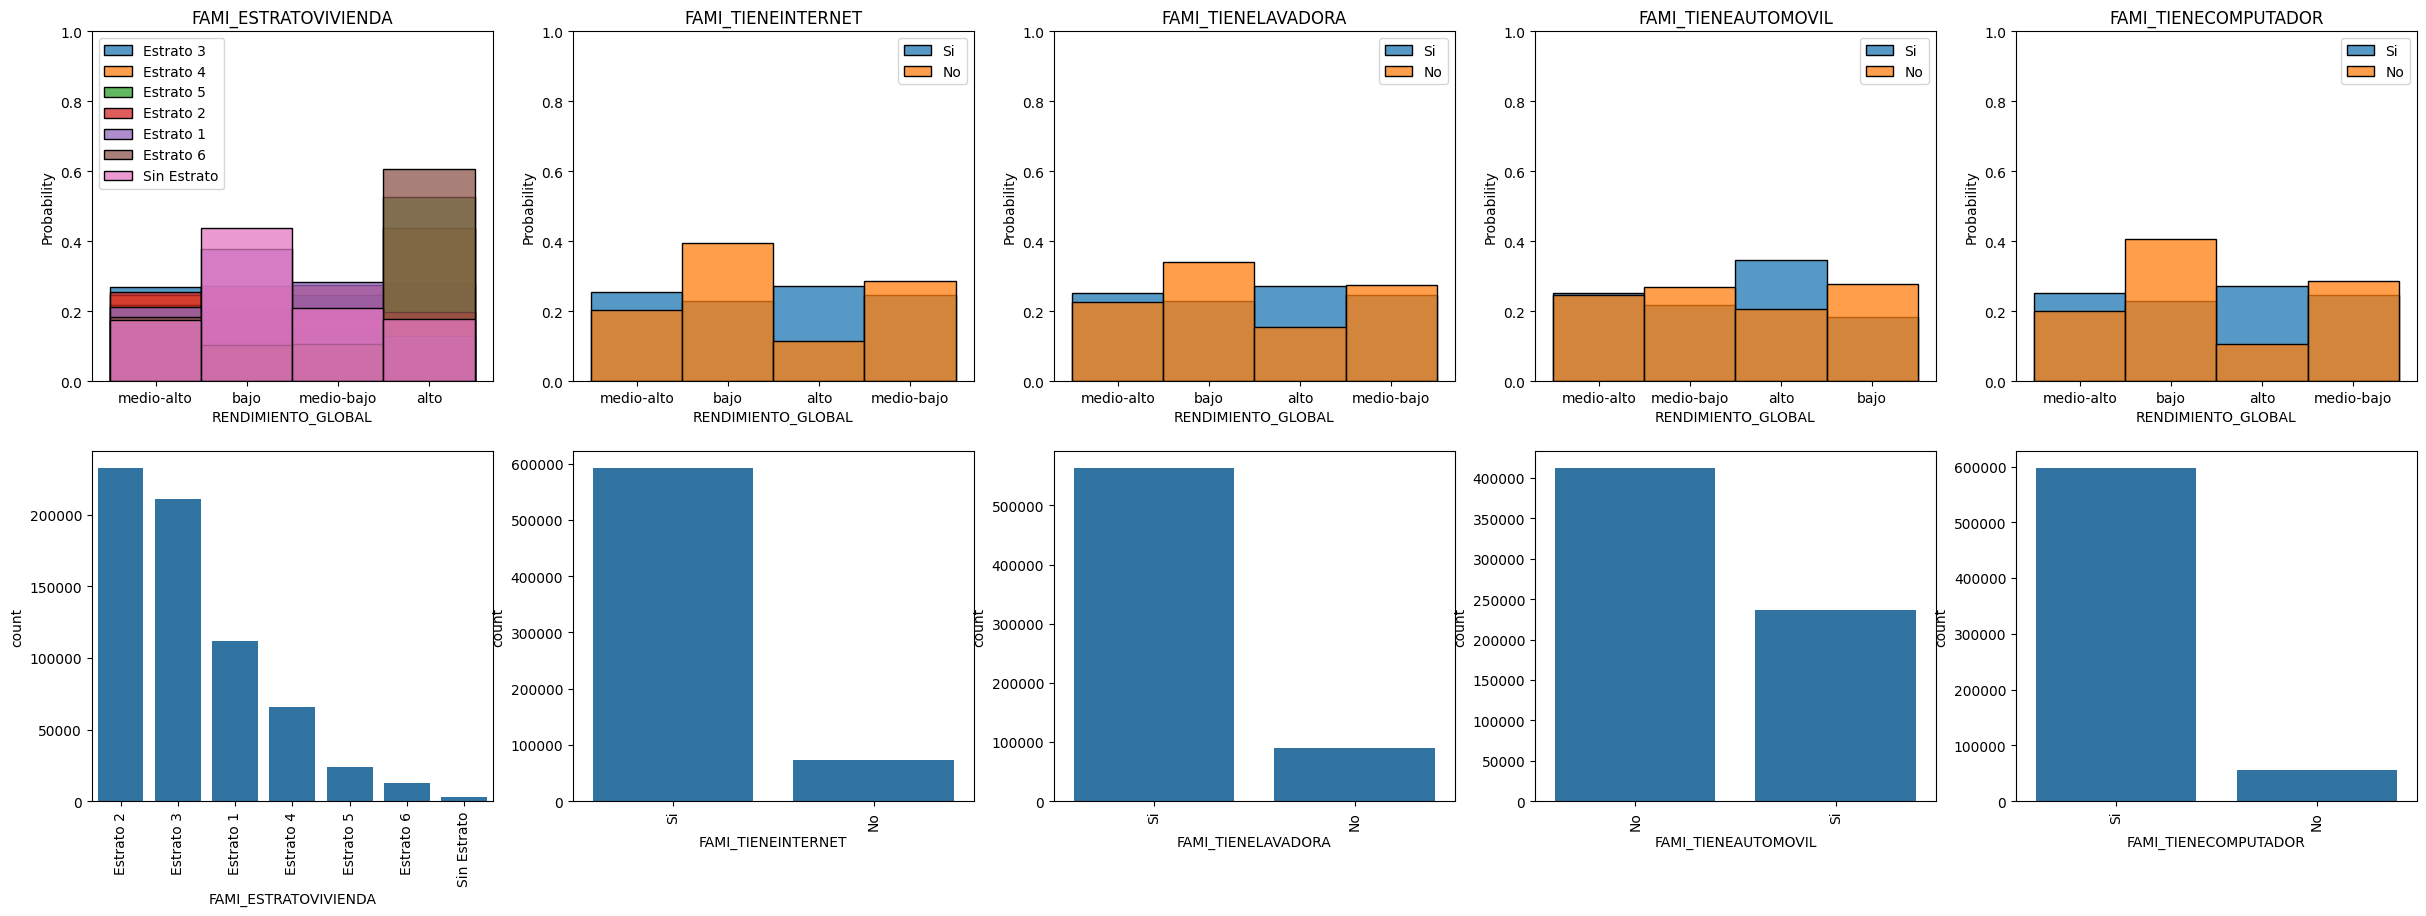

In [ ]:
plt.figure(figsize=(30,10))
columns = ["FAMI_ESTRATOVIVIENDA", "FAMI_TIENEINTERNET", "FAMI_TIENELAVADORA", "FAMI_TIENEAUTOMOVIL",
            "FAMI_TIENECOMPUTADOR"]

grades = ["bajo", "medio-bajo", "medio-alto", "alto"]

for i,c in enumerate(columns):
    plt.subplot(2,5,i+1)
    k = df[[c,"RENDIMIENTO_GLOBAL"]].dropna()
    for v in df[c].dropna().unique():
        sns.histplot(k.RENDIMIENTO_GLOBAL[k[c]==v], label=v, stat='probability');
        plt.title(c)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend()
    plt.subplot(2,5,i+6)
    vc = k[c].value_counts()
    sns.barplot(vc)
    plt.xticks(range(len(vc)), vc.index, rotation="vertical")

Inicialmente vemos una tendencia contraria en cuanto al acceso a los recursos, tendiendo a rendimientos medio bajo y bajo cuando no se tiene el acceso en contraste a rendimientos medio alto y alto cuando se tiene el acceso al recurso. Esta tendencia es contraria en el caso del acceso a un automovil

/tmp/ipython-input-22-259200466.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
/tmp/ipython-input-22-259200466.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
/tmp/ipython-input-22-259200466.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

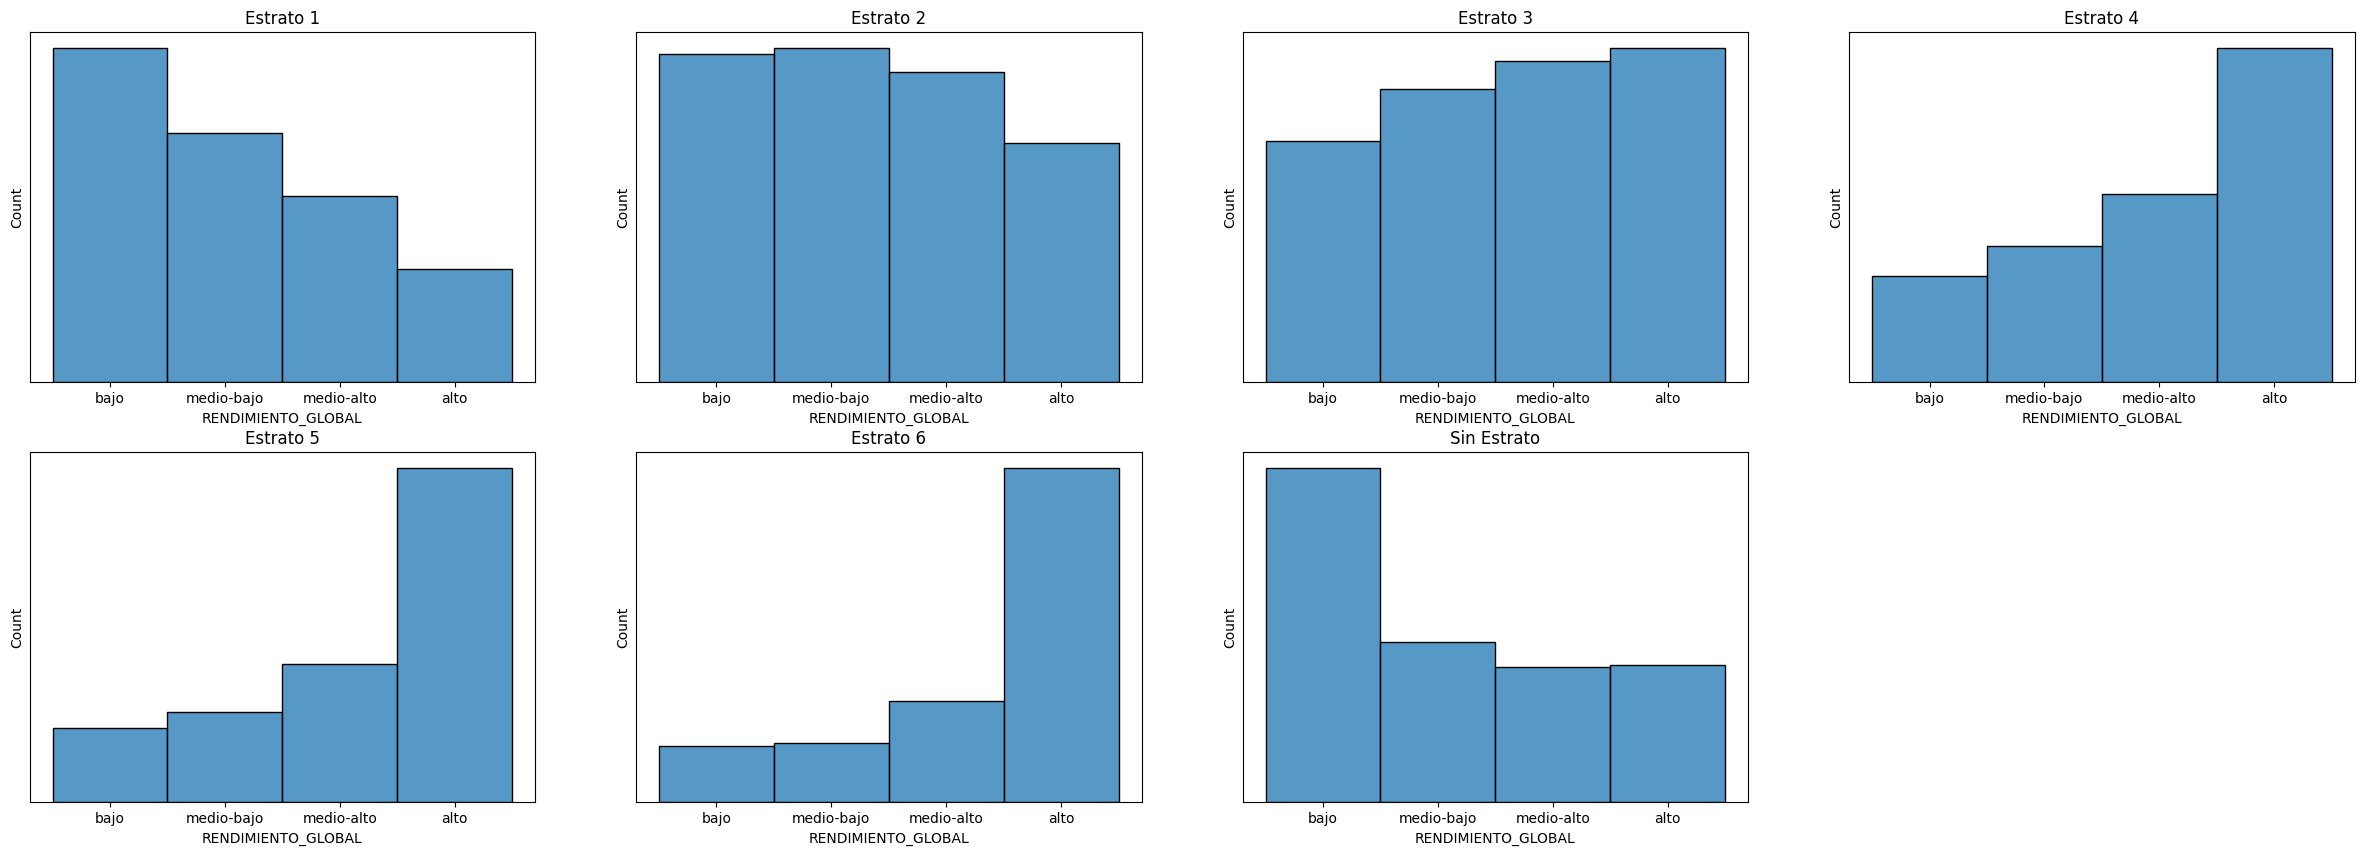

In [ ]:
plt.figure(figsize=(30,10))

k = df[["FAMI_ESTRATOVIVIENDA","RENDIMIENTO_GLOBAL"]].dropna()
grades = ["bajo", "medio-bajo", "medio-alto", "alto"]

i = 0
for v in df["FAMI_ESTRATOVIVIENDA"].sort_values().dropna().unique():
  plt.subplot(2,4,i+1)
  data = k.loc[k["FAMI_ESTRATOVIVIENDA"]==v]
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
  sns.histplot(data=data,x='RENDIMIENTO_GLOBAL');
  plt.title(v)
  plt.yticks([])
  i += 1


Al detallar el rendimiento según el estrato se confirma que este es mucho mayor cuando el estudiante pertenece a un estrato más alto. Igualmente, el comportamiento de la categoría "Sin estrato" es incluso peor que para el estrato 1 por lo que esta categoria podria representar un nivel cero para el estrato

#####Cualidades del estudiante

Inicialmente evaluamos el desempeño diferenciado en cuanto si el estudiante paga su propio estudio o no. Sería de esperar que el rendimiento sea más elevado si no los paga pues el estudiante que paga su matricula no tiene el suficiente tiempo para dedicarse profundamente a su aprendizaje pues es evidente que debe generar recursos económicos para su sostenimiento

/tmp/ipython-input-23-2811675218.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
/tmp/ipython-input-23-2811675218.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)


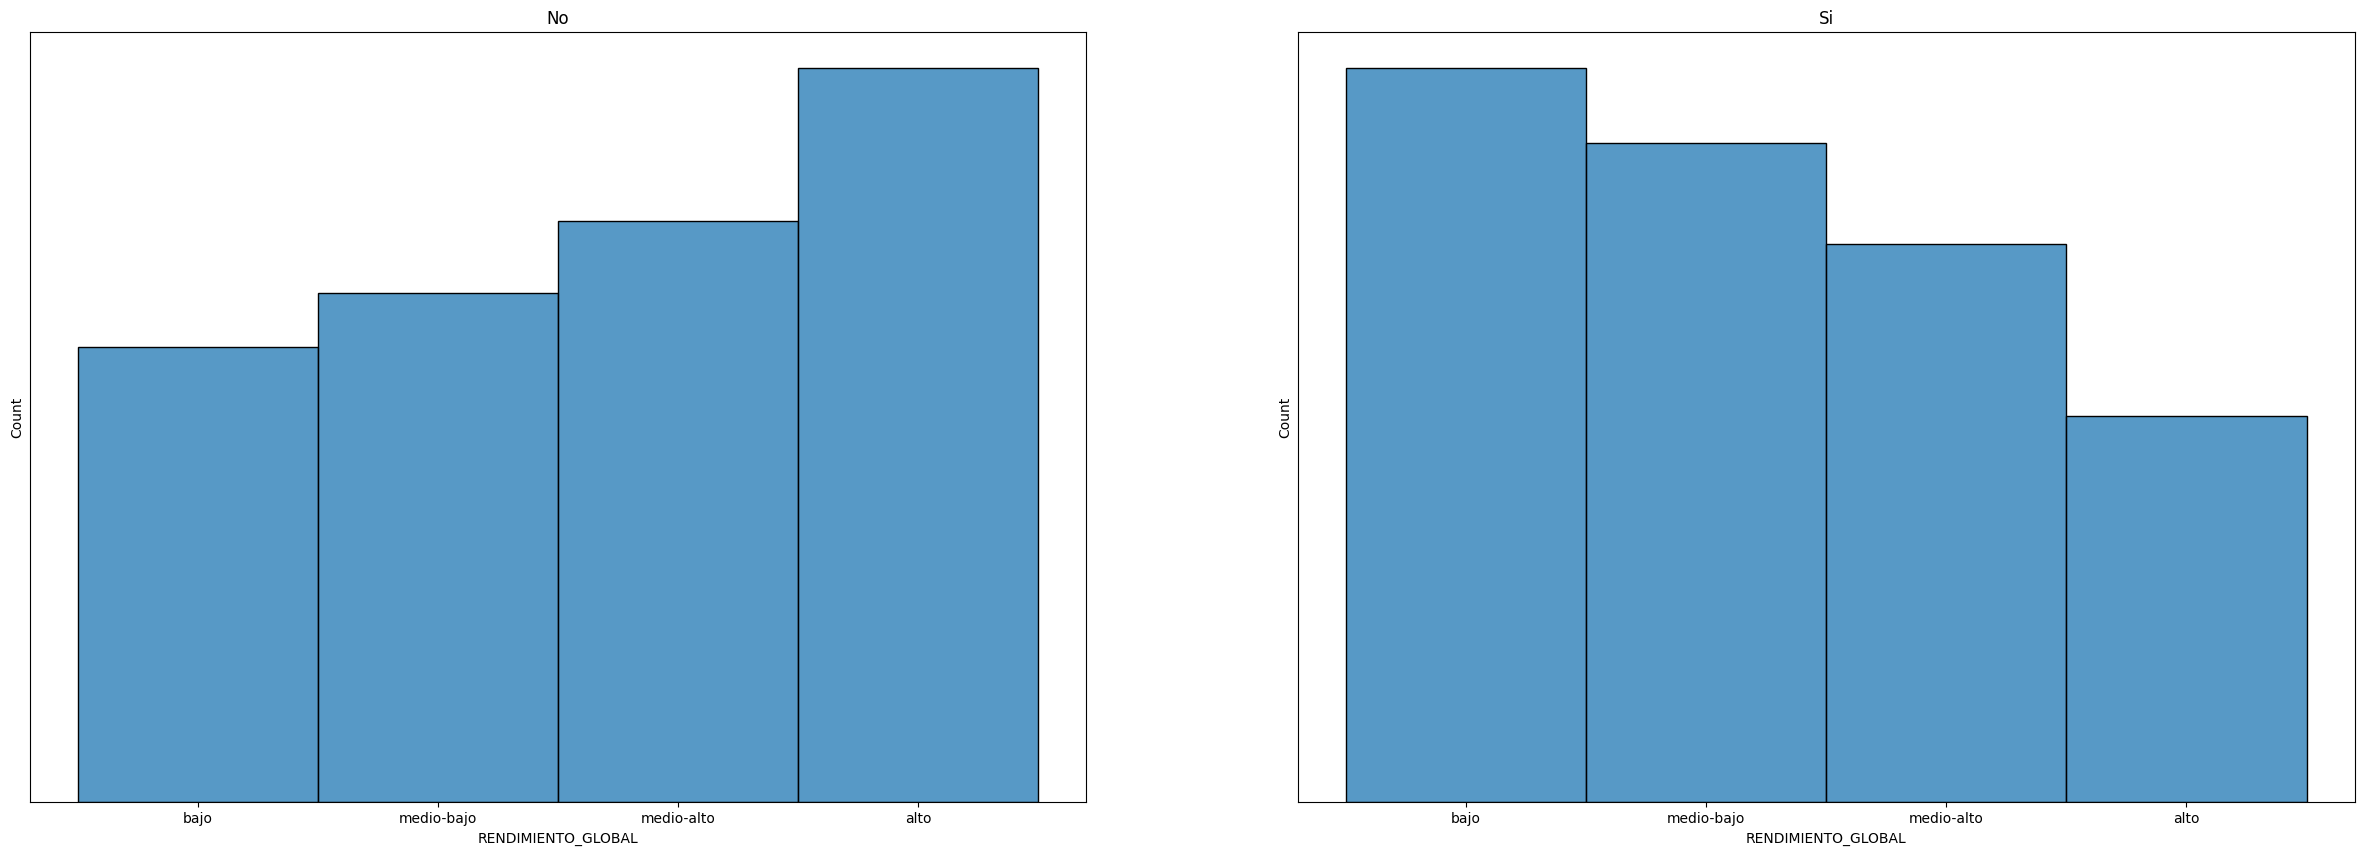

In [ ]:
plt.figure(figsize=(30,10))

k = df[["ESTU_PAGOMATRICULAPROPIO","RENDIMIENTO_GLOBAL"]].dropna()
grades = ["bajo", "medio-bajo", "medio-alto", "alto"]

i = 0
for v in df["ESTU_PAGOMATRICULAPROPIO"].sort_values().dropna().unique():
  plt.subplot(1,2,i+1)
  data = k.loc[k["ESTU_PAGOMATRICULAPROPIO"]==v]
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
  sns.histplot(data=data,x='RENDIMIENTO_GLOBAL');
  plt.title(v)
  plt.yticks([])
  i += 1

Se estudia ahora el desempeño de los estudiantes de acuerdo a su lugar de residencia.

/tmp/ipython-input-24-2581505740.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
/tmp/ipython-input-24-2581505740.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
/tmp/ipython-input-24-2581505740.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

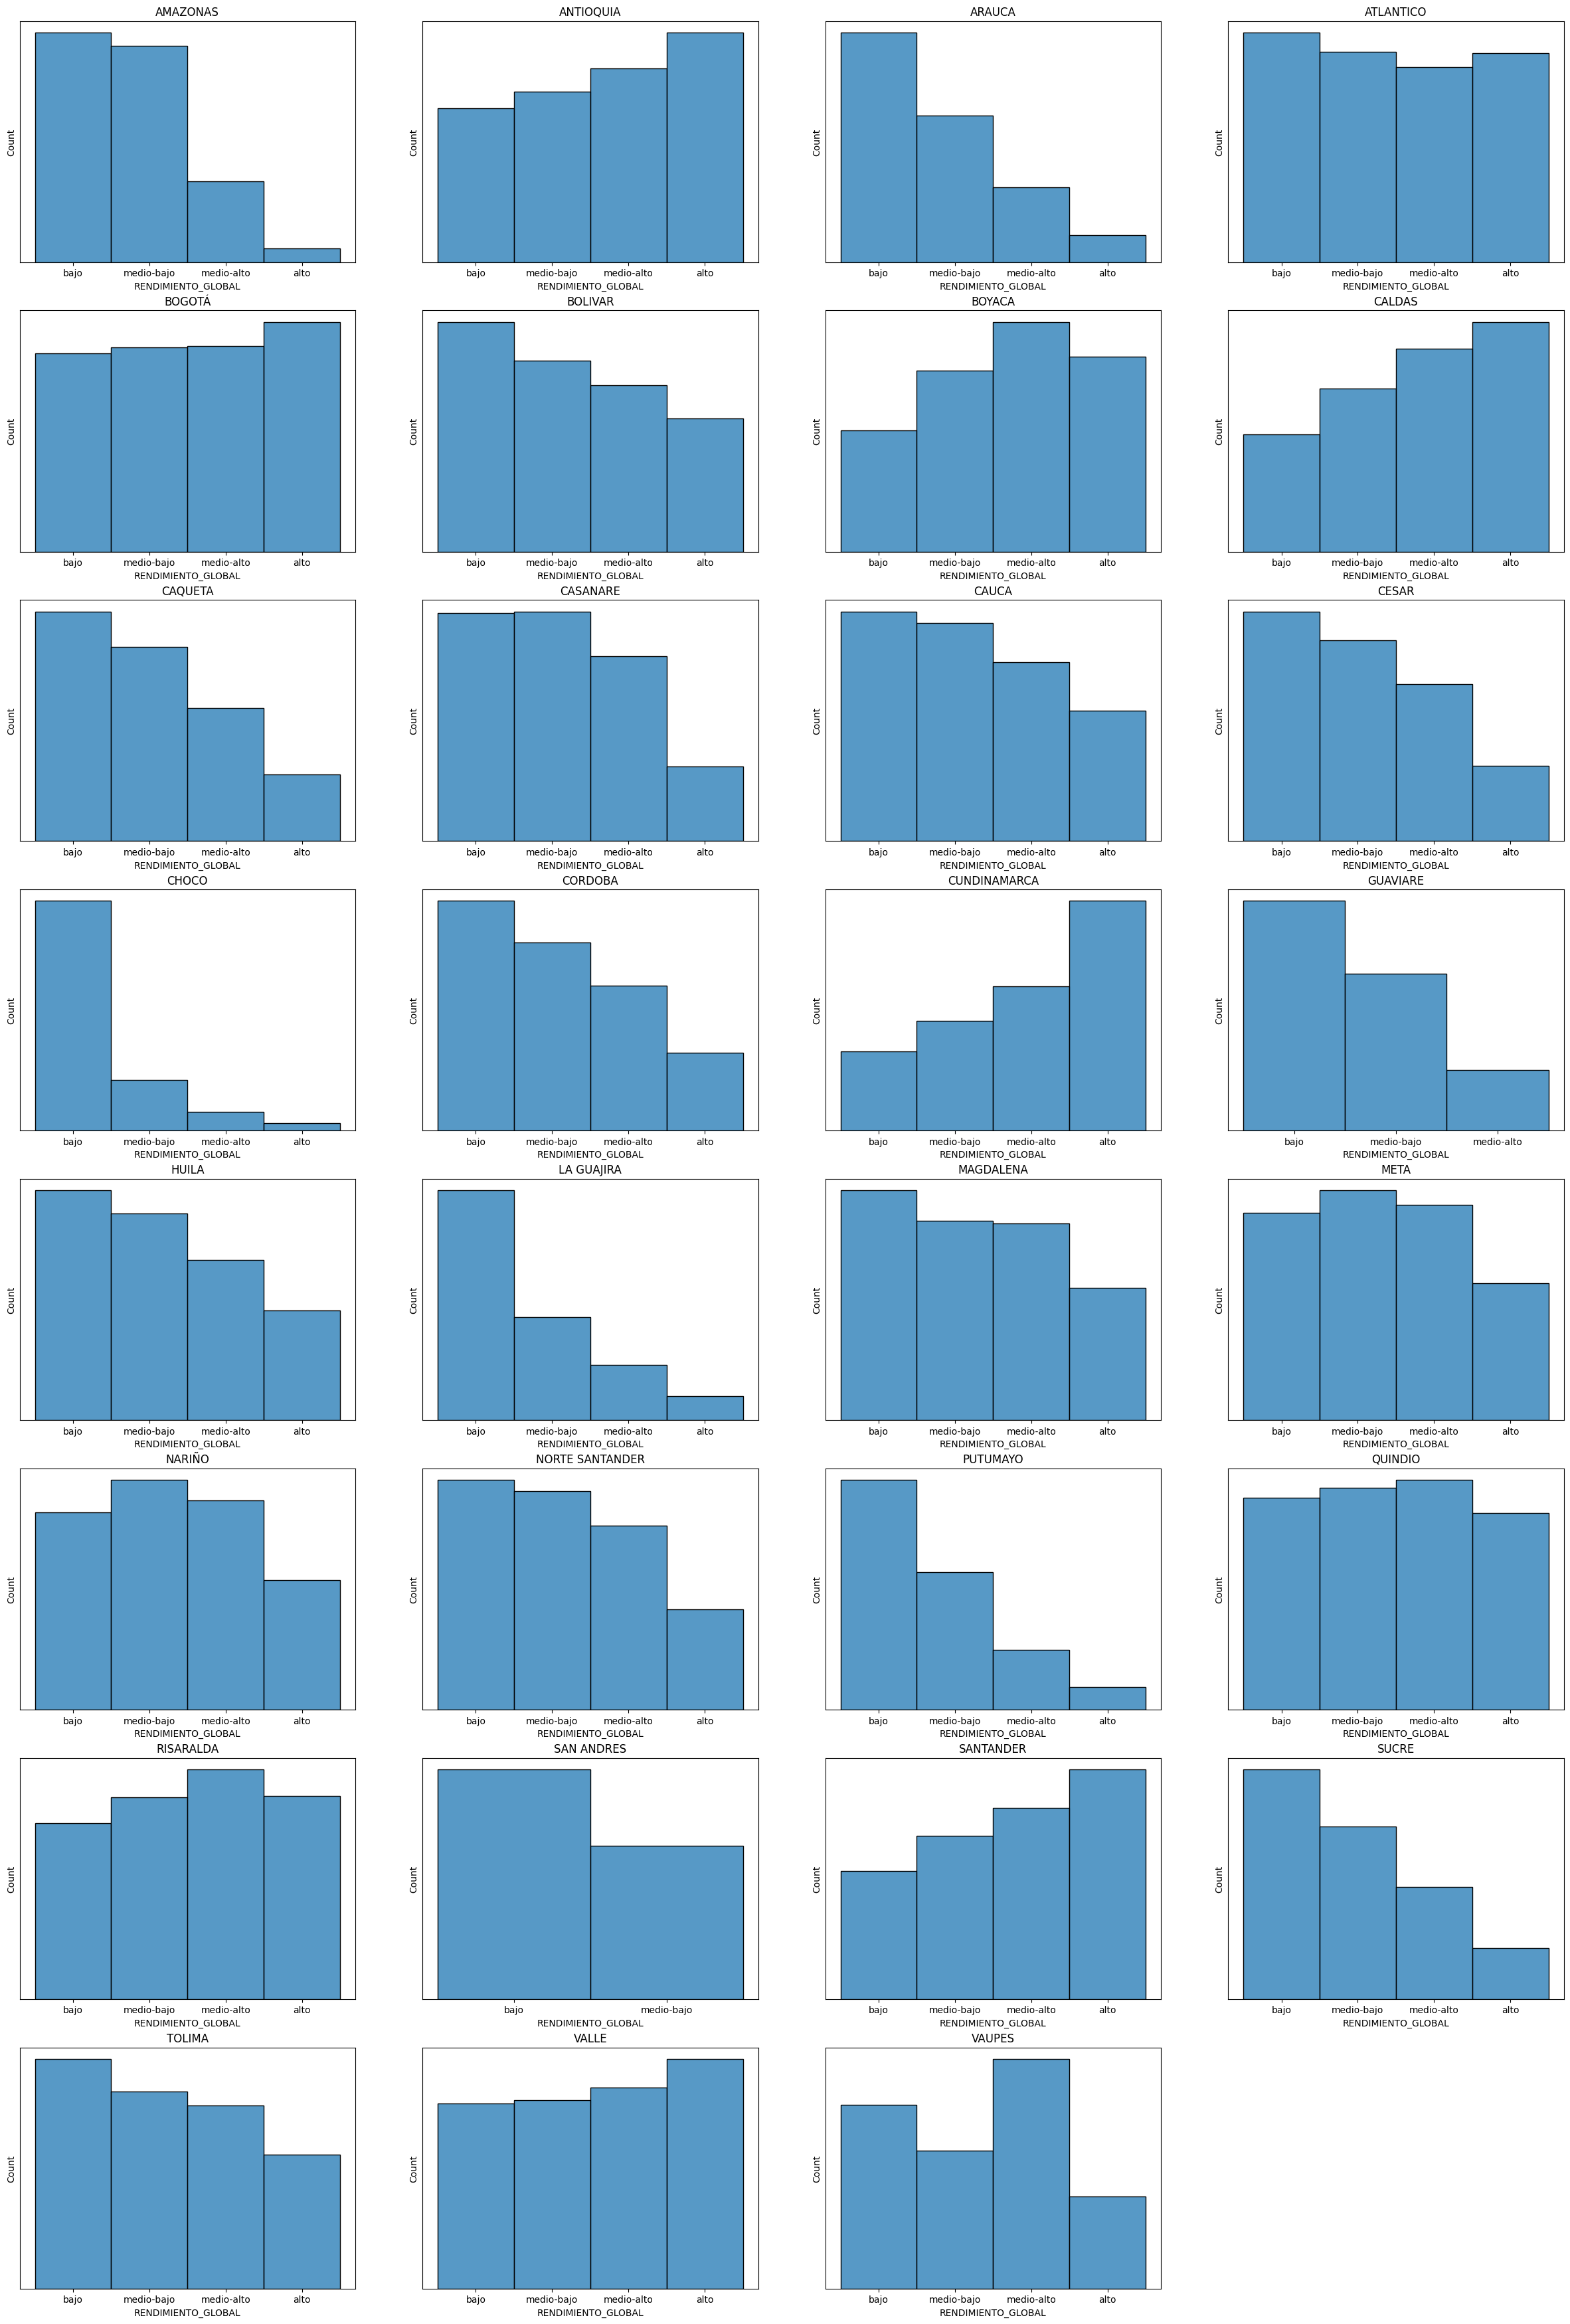

In [ ]:
plt.figure(figsize=(30,50))

column = "ESTU_PRGM_DEPARTAMENTO"

k = df[[column,"RENDIMIENTO_GLOBAL"]].dropna()
grades = ["bajo", "medio-bajo", "medio-alto", "alto"]

i = 0
for v in df[column].sort_values().dropna().unique():
  plt.subplot(9,4,i+1)
  data = k.loc[k[column]==v]
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
  sns.histplot(data=data,x='RENDIMIENTO_GLOBAL');
  plt.title(v)
  plt.yticks([])
  i += 1

Vemos que el desempeño tiende a ser alto en departamentos del centro del país tales como Antioquia, Caldas y Cundinamarca, en donde el distrito capital muestra una distribución casi uniforme. En los demás departamentos se tiene una tendencia hacia bajos desempeños y existen casos especiales en los cuales ni siquiera se logran un desempeño alto o medio alto.

#####Educación padres

Es de esperar que los hijos de padres con niveles más altos de educación tengan mejores rendimientos en las pruebas.

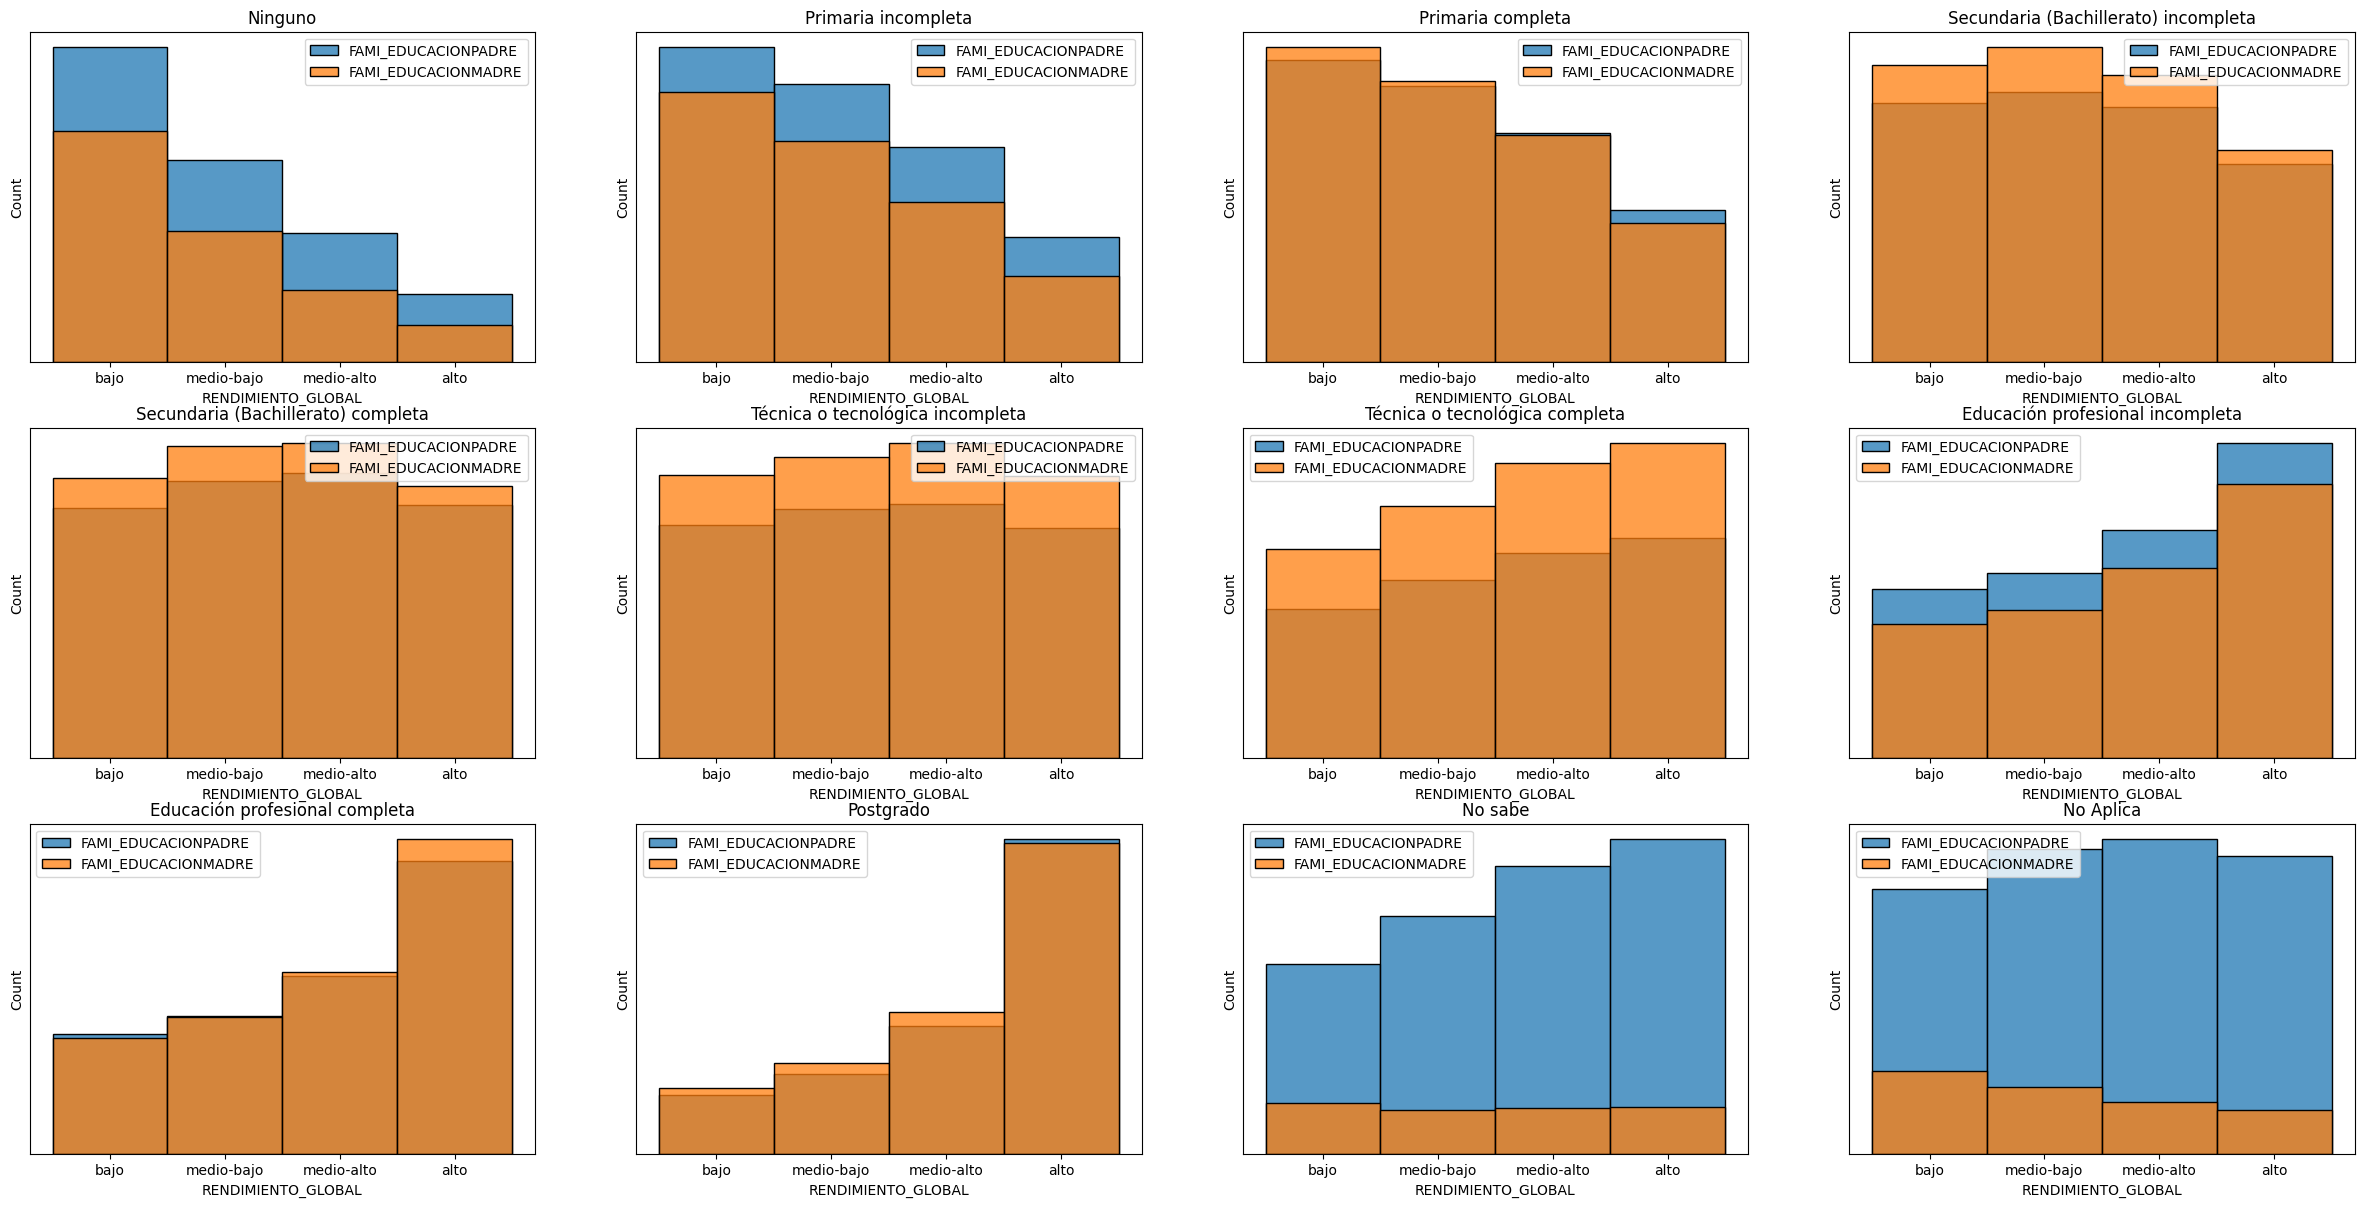

In [ ]:
education = []
education.append("Ninguno")
education.append("Primaria incompleta")
education.append("Primaria completa")
education.append("Secundaria (Bachillerato) incompleta")
education.append("Secundaria (Bachillerato) completa")
education.append("Técnica o tecnológica incompleta")
education.append("Técnica o tecnológica completa")
education.append("Educación profesional incompleta")
education.append("Educación profesional completa")
education.append("Postgrado")
education.append("No sabe")
education.append("No Aplica")

plt.figure(figsize=(30,30))

column = "FAMI_EDUCACIONPADRE"
column2 = "FAMI_EDUCACIONMADRE"

k = df[[column, column2,"RENDIMIENTO_GLOBAL"]].dropna()

grades = ["bajo", "medio-bajo", "medio-alto", "alto"]

i = 0

for v in education:
  for col in [column, column2]:
    plt.subplot(6,4,i+1)
    data = k.loc[k[col]==v, [col,"RENDIMIENTO_GLOBAL"]]
    data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
    sns.histplot(data=data,x='RENDIMIENTO_GLOBAL', label=col, multiple="stack");
    plt.title(v)
    plt.legend()
    plt.yticks([])
  i += 1

Se evidencia que a medida que el nivel educativo de los padres es mayor, se tiende a que el estudiante tenga un mejor desempeño. Podemos comprobar que el caso de que el estudiante responde que no sabe la situación de educación de sus padres, el comportamiento en cuanto a rendimiento es uniforme para el caso de la madre, sin embargo, en el caso del padre tiene una tendencia similar a un nivel tecnológico. En el caso de la categoria "No Aplica" es relativamente una distribución uniforme

####Variables cuantitativas

Las columnas con valores numericos corresponden a las siguientes:

* ID
* PERIODO
* ESTU_VALORMATRICULAUNIVERSIDAD
* coef_1
* coef_2
* coef_3
* coef_4

De estas columnas, el ID del estudiante solo representa una identificación en la base de datos, por lo tanto esta no es una columna de interés para el entrenamiento del modelo. Evaluaremos si el periodo puede ser una variable que impacte en el rendimiento (Si la presentación de las pruebas en un primer semestre o a final de año puede influir en los resultados)

In [ ]:
column = 'PERIODO'
null_registers = np.sum(df[column].isna())
total = df.shape[0]
percentage = np.round(100*null_registers/total,2)
print ("Valores nulos: ", null_registers, "de un total de: ", total,
                   "Representa un porcentaje de: %.2f%%" %percentage, '\n')

not_null_total = total - null_registers
for resp in df[column].dropna().unique():
  print(resp, df[column].value_counts()[resp], \
        np.round(df[column].value_counts()[resp]/not_null_total*100,2),"%")

Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00% 

20212 171412 24.75 %
20203 171838 24.81 %
20195 180873 26.12 %
20183 164818 23.8 %
20194 1472 0.21 %
20213 1178 0.17 %
20184 254 0.04 %
20202 490 0.07 %
20196 165 0.02 %


Es posible que el registro de los datos tenga una codificación adicional o errores, puesto que la prueba solo se realiza dos veces al año por lo que es de esperar periodos del tipo 20191-20192 para el año 2019. Se estudiará la influencia del periodo en la variable respuesta para observar si es una variable que pueda influir de forma significativa


/tmp/ipython-input-27-655257861.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
/tmp/ipython-input-27-655257861.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
/tmp/ipython-input-27-655257861.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

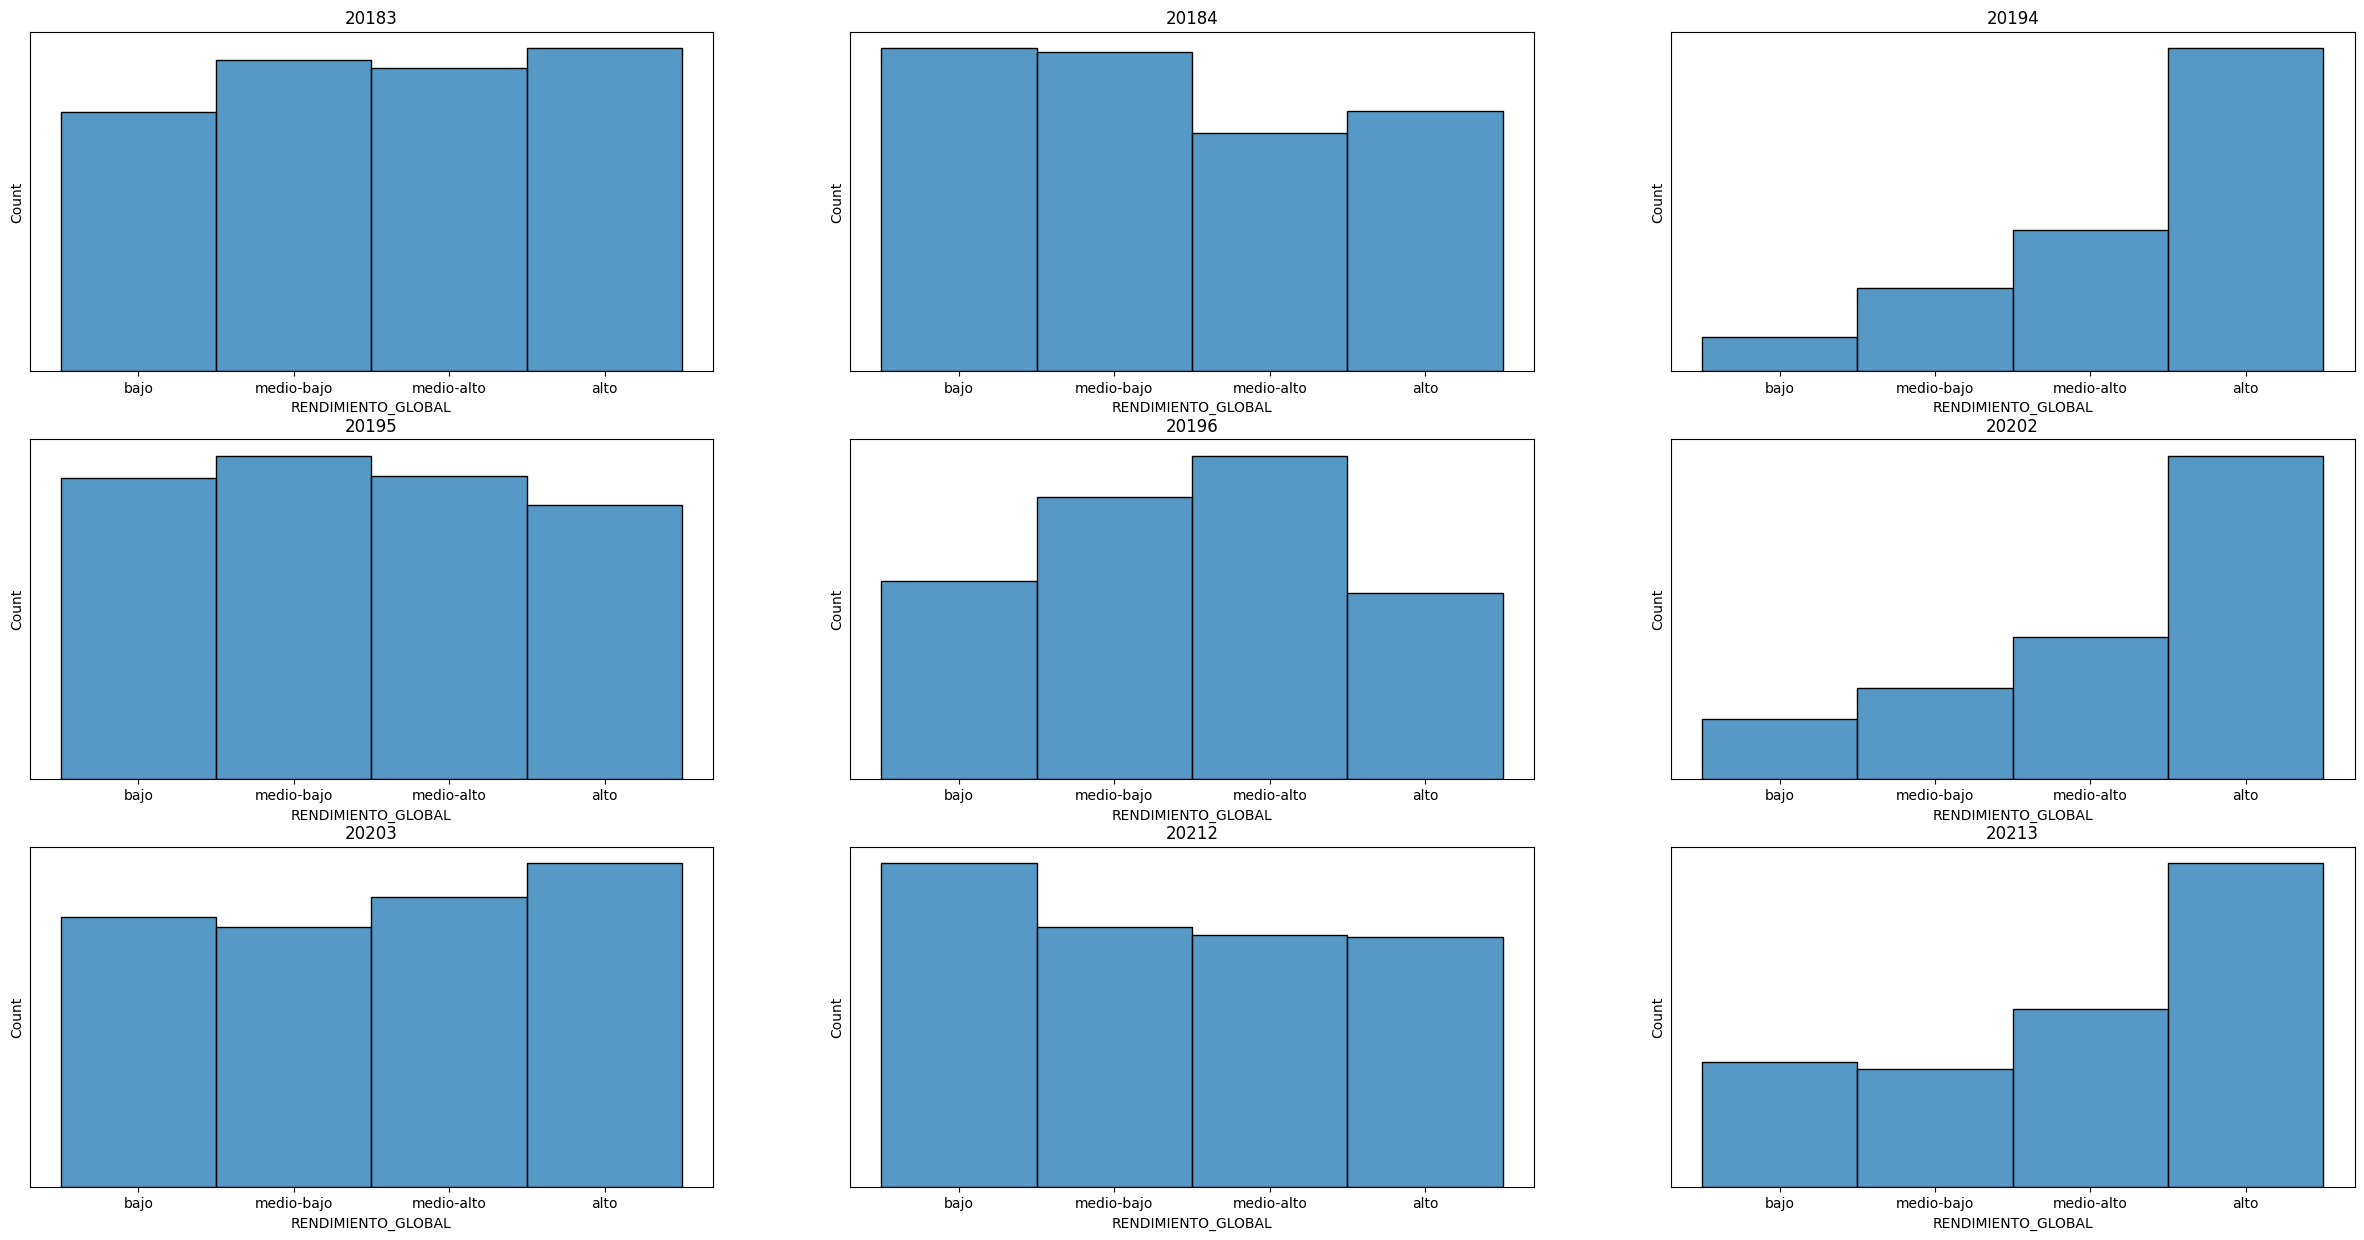

In [ ]:
plt.figure(figsize=(30,15))

column = "PERIODO"

k = df[[column,"RENDIMIENTO_GLOBAL"]].dropna()
grades = ["bajo", "medio-bajo", "medio-alto", "alto"]

i = 0
for v in df[column].sort_values().dropna().unique():
  plt.subplot(3,3,i+1)
  data = k.loc[k[column]==v]
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
  sns.histplot(data=data,x='RENDIMIENTO_GLOBAL');
  plt.title(v)
  plt.yticks([])
  i += 1

De acuerdo a las gráficas anteriores, existen variaciones del desempeño de acuerdo al periodo en que se aplicaron las pruebas.

#####Valor de matricula

Para esta variable se espera que para mayores valores de matricula, el desempeño tienda a ser más alto ya que representa una población de estrato mayor con acceso a muchos más recursos y en universidades privadas.

In [ ]:
df['ESTU_VALORMATRICULAUNIVERSIDAD'].describe()

,ESTU_VALORMATRICULAUNIVERSIDAD
count,686213
unique,8
top,Entre 1 millón y menos de 2.5 millones
freq,204048


A pesar de que esta variable se tiende a pensar como numerica, vemos que esta se ha evaluado por rangos, por lo tanto es una variable categórica aunque son intervalos ordenados.

In [ ]:
column = "ESTU_VALORMATRICULAUNIVERSIDAD"
null_registers = np.sum(df[column].isna())
total = df.shape[0]
percentage = np.round(100*null_registers/total,2)
print ("Valores nulos: ", null_registers, "de un total de: ", total,
                   "Representa un porcentaje de: %.2f%%" %percentage, '\n')

not_null_total = total - null_registers
for resp in df[column].dropna().unique():
  print(resp, df[column].value_counts()[resp], \
        np.round(df[column].value_counts()[resp]/not_null_total*100,2),"%")

Valores nulos:  6287 de un total de:  692500 Representa un porcentaje de: 0.91% 

Entre 5.5 millones y menos de 7 millones 38490 5.61 %
Entre 2.5 millones y menos de 4 millones 127430 18.57 %
Entre 4 millones y menos de 5.5 millones 69736 10.16 %
Más de 7 millones 68014 9.91 %
Entre 1 millón y menos de 2.5 millones 204048 29.74 %
Entre 500 mil y menos de 1 millón 78704 11.47 %
Menos de 500 mil 80263 11.7 %
No pagó matrícula 19528 2.85 %


/tmp/ipython-input-30-1417360349.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
/tmp/ipython-input-30-1417360349.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
/tmp/ipython-input-30-1417360349.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

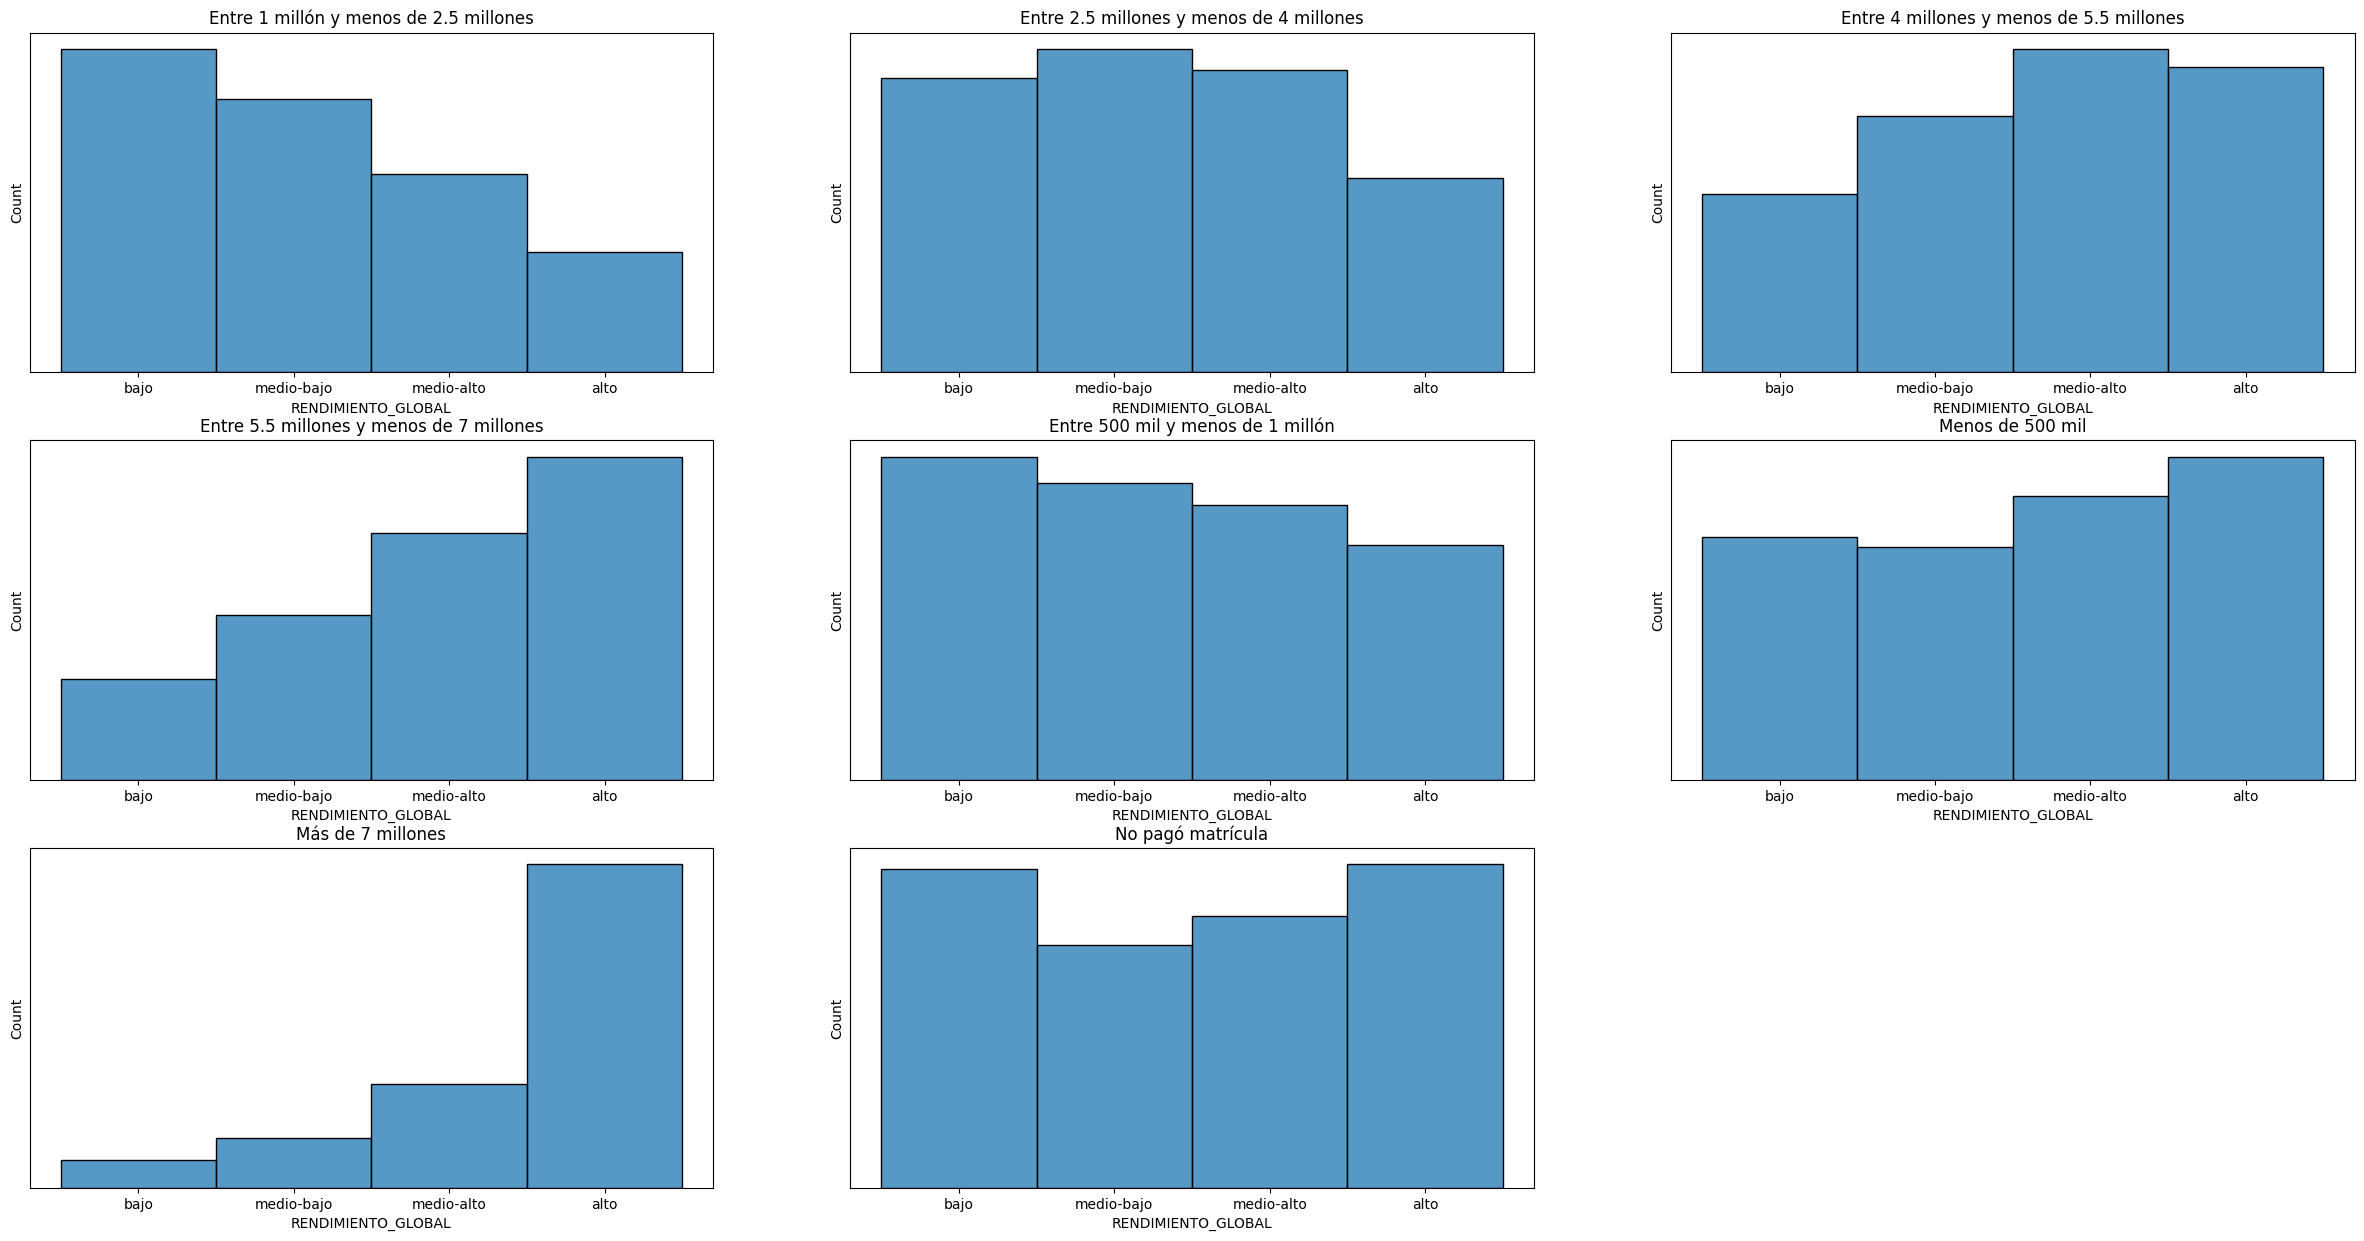

In [ ]:
plt.figure(figsize=(30,15))

column = "ESTU_VALORMATRICULAUNIVERSIDAD"

k = df[[column,"RENDIMIENTO_GLOBAL"]].dropna()
grades = ["bajo", "medio-bajo", "medio-alto", "alto"]

i = 0
for v in df[column].sort_values().dropna().unique():
  plt.subplot(3,3,i+1)
  data = k.loc[k[column]==v]
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
  sns.histplot(data=data,x='RENDIMIENTO_GLOBAL');
  plt.title(v)
  plt.yticks([])
  i += 1

La tendencia esperada se corrobora, a mayor valor de matricula mayor desempeño en las pruebas, pero a partir de matriculas mayores a 4 millones. En los rangos más bajos la tendencia es inversa excepto para matriculas de menos de 500mil (Que reflejan gran cantidad de estudiantes de universidades públicas)

####Horas de trabajo

A pesar de que es una variable claramente cuantitativa al examinar los valores encontramos que se establecen también por rangos de valores

In [ ]:
column = "ESTU_HORASSEMANATRABAJA"
null_registers = np.sum(df[column].isna())
total = df.shape[0]
percentage = np.round(100*null_registers/total,2)
print ("Valores nulos: ", null_registers, "de un total de: ", total,
                   "Representa un porcentaje de: %.2f%%" %percentage, '\n')

not_null_total = total - null_registers
for resp in df[column].dropna().unique():
  print(resp, df[column].value_counts()[resp], \
        np.round(df[column].value_counts()[resp]/not_null_total*100,2),"%")

Valores nulos:  30857 de un total de:  692500 Representa un porcentaje de: 4.46% 

Menos de 10 horas 87191 13.18 %
0 116550 17.62 %
Más de 30 horas 249352 37.69 %
Entre 21 y 30 horas 92693 14.01 %
Entre 11 y 20 horas 115857 17.51 %


Se evalua igualmente su influencia sobre la variable respuesta, se espera que un estudiante que tenga mayor responsabilidad laboral obtenga un rendimiento más bajo en las pruebas

/tmp/ipython-input-32-2423501149.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
/tmp/ipython-input-32-2423501149.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
/tmp/ipython-input-32-2423501149.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

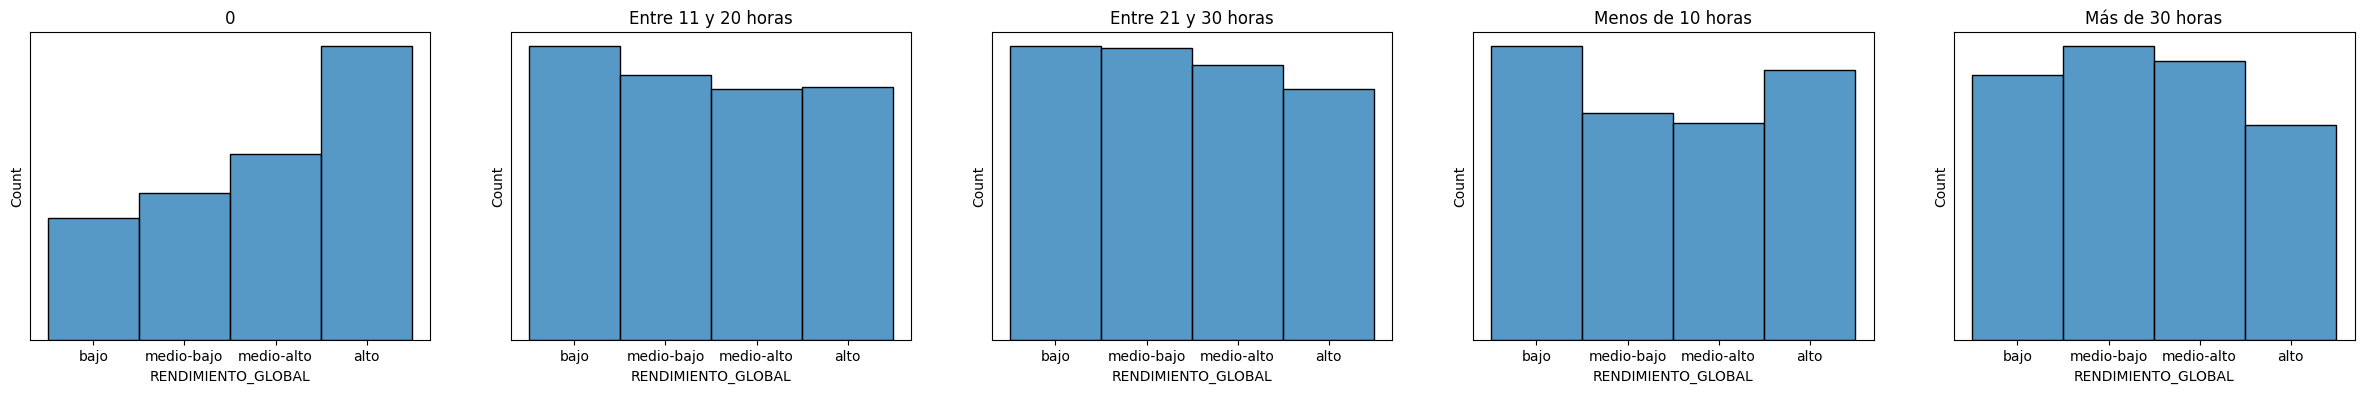

In [ ]:
plt.figure(figsize=(30,4))

column = "ESTU_HORASSEMANATRABAJA"

k = df[[column,"RENDIMIENTO_GLOBAL"]].dropna()
grades = ["bajo", "medio-bajo", "medio-alto", "alto"]

i = 0
for v in df[column].sort_values().dropna().unique():
  plt.subplot(1,5,i+1)
  data = k.loc[k[column]==v]
  data['RENDIMIENTO_GLOBAL'] = pd.Categorical(data['RENDIMIENTO_GLOBAL'], categories=grades, ordered=True)
  sns.histplot(data=data,x='RENDIMIENTO_GLOBAL');
  plt.title(v)
  plt.yticks([])
  i += 1

####Coeficientes

Finalmente existen varios coeficientes dentro del dataset que de acuerdo a la información sobre éste en la competencia Kaggle, corresponden a coeficientes que equipos de estudio han desarrollado que podría ayudar a la clasificación.

In [ ]:
df_coef = ['coef_1','coef_2','coef_3','coef_4']

for column in df_coef:

  null_registers = np.sum(df[column].isna())
  total = df.shape[0]
  percentage = np.round(100*null_registers/total,2)
  print(column)
  print ("Valores nulos: ", null_registers, "de un total de: ", total,
                    "Representa un porcentaje de: %.2f%%" %percentage, '\n')

  print('\n', df[column].describe(), '\n')

coef_1
Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00% 


 count    692500.000000
mean          0.268629
std           0.122130
min           0.000000
25%           0.203000
50%           0.240000
75%           0.314000
max           0.657000
Name: coef_1, dtype: float64 

coef_2
Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00% 


 count    692500.000000
mean          0.259996
std           0.093480
min           0.000000
25%           0.212000
50%           0.271000
75%           0.309000
max           0.487000
Name: coef_2, dtype: float64 

coef_3
Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00% 


 count    692500.000000
mean          0.262087
std           0.058862
min           0.000000
25%           0.254000
50%           0.276000
75%           0.293000
max           0.320000
Name: coef_3, dtype: float64 

coef_4
Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00% 


 cou

Estos coeficientes tienen medias similares pero con variaciones decrecientes, lo que representa además un rango de valores decreciente. Estudiamos entonces su impacto en la variable respuesta, para esto, evaluamos cada coeficiente construyendo un histograma por cada categoría de desempeño

/tmp/ipython-input-34-2752237826.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(k.loc[k[goal_variable]==v, [coef]], label=v);
/tmp/ipython-input-34-2752237826.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(k.loc[k[goal_variable]==v, [coef]], label=v);
/tmp/ipython-input-34-2752237826

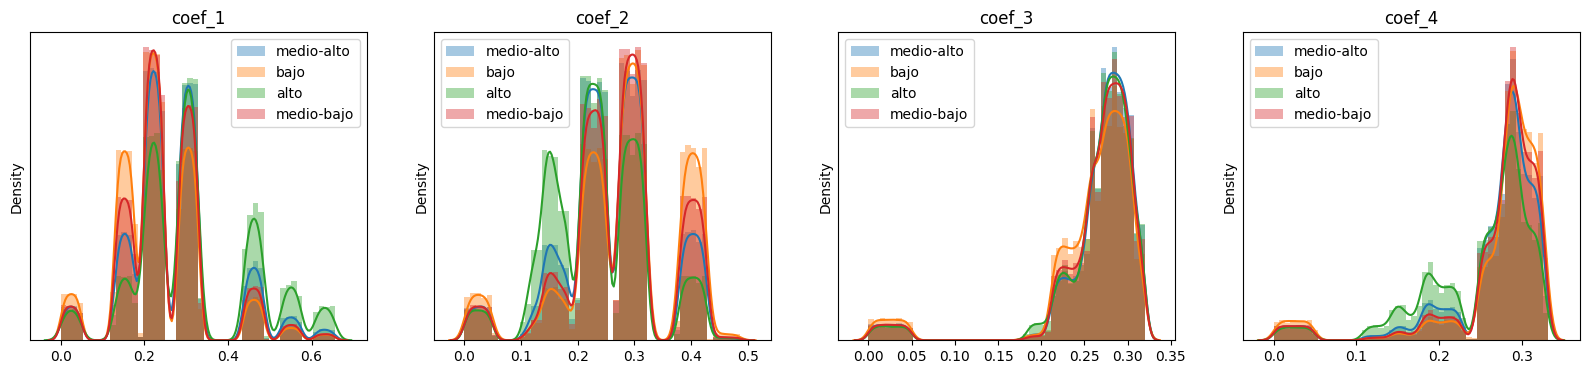

In [ ]:
df_coef = ['coef_1','coef_2','coef_3','coef_4']
grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
goal_variable = "RENDIMIENTO_GLOBAL"

plt.figure(figsize=(20,4))
for i,coef in enumerate(df_coef):
  plt.subplot(1,4,i+1)
  k = df[[coef,goal_variable]].dropna()
  for v in df[goal_variable].dropna().unique():
      sns.distplot(k.loc[k[goal_variable]==v, [coef]], label=v);
      plt.title(coef)
  plt.yticks([])
  plt.legend()

A pesar que las distribuciones son similares en forma para cada una de las categorías de rendimiento, los picos varían en altura, lo que hace que los coeficientes 1, 2 y 4 si ayuden a determinar el desempeño. El coeficiente 3 parece no tener mayor impacto

##Transformación de los datos

###Variables categóricas de Si o No

La transformación inicial consiste en convertir las columnas categóricas que describen el acceso a los recursos mediante si o no en valores númericos "binarios" 0 para no y 1 para si, sin eliminar ni cambiar los valores nulos

In [ ]:
df_copy = df.copy()

columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','FAMI_TIENECOMPUTADOR','ESTU_PAGOMATRICULAPROPIO']

for col in columns:
  not_null_column =  df_copy.loc[~df_copy[col].isna()]
  not_null_column = (not_null_column =="Si").astype(int)
  df_copy.loc[~df_copy[col].isna(), col] = not_null_column[col]
  print(np.sum(df_copy[col].isna()))
  print(df_copy[col].unique())
df_copy[columns].head()

26629
[1 0 nan]
39773
[1 0 nan]
43623
[1 0 nan]
38103
[1 0 nan]
6498
[0 1 nan]


,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,FAMI_TIENECOMPUTADOR,ESTU_PAGOMATRICULAPROPIO
0,1,1,1,1,0
1,0,1,0,1,0
2,1,1,0,0,0
3,1,1,0,1,0
4,1,1,1,1,0


In [ ]:
col = 'ESTU_PRIVADO_LIBERTAD'
columns.append(col)

not_null_column =  df_copy.loc[~df_copy[col].isna()]
not_null_column = (not_null_column =='S').astype(int)
df_copy.loc[~df_copy[col].isna(), col] = not_null_column[col]
print(np.sum(df_copy[col].isna()))
print(df_copy[col].unique())
df_copy[columns].head()


0
[0 1]


,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,FAMI_TIENECOMPUTADOR,ESTU_PAGOMATRICULAPROPIO,ESTU_PRIVADO_LIBERTAD
0,1,1,1,1,0,0
1,0,1,0,1,0,0
2,1,1,0,0,0,0
3,1,1,0,1,0,0
4,1,1,1,1,0,0


###Variables categóricas que representan un orden

Para varias de las variables es posible cambiar los valores a enteros ordenados que implican un mismo orden en las categorias, esto es válido para el estrato socioeconomico, el nivel de estudio de los padres, el número de horas semanales que trabaja el estudiante y el valor de la matricula que paga el estudiante e inclusive el periodo de presentación de las pruebas (orden temporal)

In [ ]:
def to_ordered_categories(column, values):
  keys = [int(i) for i in range(len(values))]
  replacement = dict(zip(values, keys))
  df_copy[column] = df_copy[column].replace(replacement)

####Estrato

In [ ]:
values = ["Sin Estrato", "Estrato 1", "Estrato 2", "Estrato 3", "Estrato 4", "Estrato 5", "Estrato 6"]
to_ordered_categories("FAMI_ESTRATOVIVIENDA", values)
df_copy['FAMI_ESTRATOVIVIENDA'].head()
df_copy['FAMI_ESTRATOVIVIENDA'].unique()

/tmp/ipython-input-37-2740748343.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


array([ 3.,  4.,  5.,  2.,  1., nan,  6.,  0.])

####Nivel estudio padres

In [ ]:
education = []
education.append("Ninguno")
education.append("Primaria incompleta")
education.append("Primaria completa")
education.append("Secundaria (Bachillerato) incompleta")
education.append("Secundaria (Bachillerato) completa")
education.append("Técnica o tecnológica incompleta")
education.append("Técnica o tecnológica completa")
education.append("Educación profesional incompleta")
education.append("Educación profesional completa")
education.append("Postgrado")
education.append("No sabe")
education.append("No Aplica")

to_ordered_categories("FAMI_EDUCACIONPADRE", education)
df_copy['FAMI_EDUCACIONPADRE'].head()
print(df_copy['FAMI_EDUCACIONPADRE'].unique())

to_ordered_categories("FAMI_EDUCACIONMADRE", education)
print(df_copy['FAMI_EDUCACIONMADRE'].unique())
df_copy['FAMI_EDUCACIONMADRE'].head()

/tmp/ipython-input-37-2740748343.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


[ 5.  6.  4. 10.  2.  8.  7.  1.  9. nan  3.  0. 11.]
[ 9.  5.  4.  2.  6.  3.  7.  8.  1. nan  0. 11. 10.]


,FAMI_EDUCACIONMADRE
0,9.0
1,5.0
2,4.0
3,4.0
4,2.0


####Horas semanales de trabajo

In [ ]:
df['ESTU_HORASSEMANATRABAJA'].unique()

array(['Menos de 10 horas', '0', 'Más de 30 horas', 'Entre 21 y 30 horas',
       'Entre 11 y 20 horas', nan], dtype=object)

In [ ]:
values = ['0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas']
to_ordered_categories("ESTU_HORASSEMANATRABAJA", values)
df_copy['ESTU_HORASSEMANATRABAJA'].head()

/tmp/ipython-input-37-2740748343.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


,ESTU_HORASSEMANATRABAJA
0,1.0
1,0.0
2,4.0
3,0.0
4,3.0


In [ ]:
print(df_copy['ESTU_HORASSEMANATRABAJA'].unique())

[ 1.  0.  4.  3.  2. nan]


####Valor de la matricula

In [ ]:
df['ESTU_VALORMATRICULAUNIVERSIDAD'].unique()

array(['Entre 5.5 millones y menos de 7 millones',
       'Entre 2.5 millones y menos de 4 millones',
       'Entre 4 millones y menos de 5.5 millones', 'Más de 7 millones',
       'Entre 1 millón y menos de 2.5 millones',
       'Entre 500 mil y menos de 1 millón', 'Menos de 500 mil',
       'No pagó matrícula', nan], dtype=object)

In [ ]:
values = ['No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón', 'Entre 1 millón y menos de 2.5 millones',
          'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones',
          'Entre 5.5 millones y menos de 7 millones','Más de 7 millones']

to_ordered_categories("ESTU_VALORMATRICULAUNIVERSIDAD", values)
print(df_copy['ESTU_VALORMATRICULAUNIVERSIDAD'].unique())
df_copy['ESTU_VALORMATRICULAUNIVERSIDAD'].head()

[ 6.  4.  5.  7.  3.  2.  1.  0. nan]


/tmp/ipython-input-37-2740748343.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


,ESTU_VALORMATRICULAUNIVERSIDAD
0,6.0
1,4.0
2,4.0
3,5.0
4,4.0


####Periodo

In [ ]:
df['PERIODO'].unique()

array([20212, 20203, 20195, 20183, 20194, 20213, 20184, 20202, 20196])

In [ ]:
values = [20183, 20184, 20194, 20195, 20196, 20202, 20203, 20212, 20213]

to_ordered_categories("PERIODO", values)
print(df_copy['PERIODO'].unique())
df_copy['PERIODO'].head()

[7 6 3 0 2 8 1 5 4]


,PERIODO
0,7
1,7
2,6
3,3
4,7


####Variable respuesta

In [ ]:
grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
to_ordered_categories("RENDIMIENTO_GLOBAL", grades)
print(df_copy['RENDIMIENTO_GLOBAL'].unique())
df_copy['RENDIMIENTO_GLOBAL'].head()

[2 0 3 1]


/tmp/ipython-input-37-2740748343.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


,RENDIMIENTO_GLOBAL
0,2
1,0
2,0
3,3
4,1


###Variables categóricas sin orden

Para este tipo de variables se usará la ténica de reemplazo one-hot, transformando la columna en varias, esto se aplicará para las columnas Departamento y programa académico. Teniendo en cuenta la gran cantidad de programas y departamentos, es posible que sea necesario intentar categorizar dichos valores en categorías mayores, por ejemplo, los programas clasificarlos por areas generales de estudio: Ciencias, ingenierias, tecnología, etc. Para los departamentos, podriamos generar una clasificación por regiones como region centro, costa y especial, esta última comprendería aquellos departamentos vistos donde el desempeño tiende a ser bajo.

Se exploraran las dos formas de transformación, inicialmente convirtiendo todos los posibles valores a una columna distinta

In [ ]:
def to_onehot(x):
    values = np.unique(x)
    r = np.r_[[np.argwhere(i==values)[0][0] for i in x]]
    return np.eye(len(values))[r].astype(int)


In [ ]:
def replace_columns_with_onehot(d, col):
    k = to_onehot(d[col].values)
    r = pd.DataFrame(k, columns=["%s_%d"%(col, i) for i in range(k.shape[1])], index=d.index).join(d)
    del(r[col])
    return r

In [ ]:
#df_copy = replace_columns_with_onehot(df_copy, 'ESTU_PRGM_ACADEMICO')
#df_copy.shape()

# Fallo en procesamiento

In [ ]:
df_copy = replace_columns_with_onehot(df_copy, 'ESTU_PRGM_DEPARTAMENTO')

In [ ]:
del(df_copy['ID'])

####Categorías de programas académicos

Agruparemos por disciplinas o aréas del conocimiento asi:


**Ciencias Naturales y exactas:**
Incluye disciplinas como la matemática, estadistica, la física, la química, la biología, la geología, la astronomía, etc.


**Ciencias Sociales:**
Comprende áreas como la historia, la sociología, la antropología, la economía, la política, etc.


**Humanidades:**
Se enfocan en el estudio de la cultura, la lengua, la literatura, la filosofía, el arte, etc.


**Ciencias de la Salud:**
Incluye áreas como la medicina, la enfermería, la farmacia, la odontología, la fisioterapia, etc.


**Ingeniería y Arquitectura:**
Incluye disciplinas como la ingeniería civil, mecánica, eléctrica, química, arquitectura, urbanismo, etc.


**Agronomía y Veterinaria:**
Se enfoca en el estudio de la agricultura, la ganadería, la producción animal, etc.


**Ciencias de la Educación:**
Estudia los procesos de enseñanza y aprendizaje, la didáctica, la psicopedagogía, etc.


**Bellas Artes:**
Incluye áreas como la música, la pintura, la escultura, la danza, el teatro, etc.


**Economía, Administración y Contaduría:**
Se centra en el estudio de la gestión empresarial, la administración pública, la contabilidad, etc.



In [ ]:
def normalize_word(word):
  word = word.lower()
  word = word.replace('á','a')
  word = word.replace('é','e')
  word = word.replace('í','i')
  word = word.replace('ó','o')
  word = word.replace('ú','u')
  return word

def check_word_in(word, program_name):
  program_name = normalize_word(program_name)
  splitted = program_name.split()
  if word in splitted:
    return True
  else:
    return False

normalize = np.vectorize(normalize_word)
check = np.vectorize(check_word_in)

In [ ]:
knowledge_area = ['CIENCIAS_NATURALES','CIENCIAS_SOCIALES','HUMANIDADES','CIENCIAS_SALUD','INGENIERIA','AGRO_VETERINARIA',
        'EDUCACION','BELLAS ARTES', 'ADMON_CONTADURIA']

for area in knowledge_area:
  column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =[area])
  df_copy = df_copy.join(column)

df_copy.head()

,ESTU_PRGM_DEPARTAMENTO_0,ESTU_PRGM_DEPARTAMENTO_1,ESTU_PRGM_DEPARTAMENTO_2,ESTU_PRGM_DEPARTAMENTO_3,ESTU_PRGM_DEPARTAMENTO_4,ESTU_PRGM_DEPARTAMENTO_5,ESTU_PRGM_DEPARTAMENTO_6,ESTU_PRGM_DEPARTAMENTO_7,ESTU_PRGM_DEPARTAMENTO_8,ESTU_PRGM_DEPARTAMENTO_9,...,coef_4,CIENCIAS_NATURALES,CIENCIAS_SOCIALES,HUMANIDADES,CIENCIAS_SALUD,INGENIERIA,AGRO_VETERINARIA,EDUCACION,BELLAS ARTES,ADMON_CONTADURIA
0,0,0,0,0,1,0,0,0,0,0,...,0.267,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0.264,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0.264,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0.190,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0.294,0,0,0,0,0,0,0,0,0


In [ ]:
normalize(df_copy['ESTU_PRGM_ACADEMICO'])

array(['enfermeria', 'derecho', 'mercadeo y publicidad', ...,
       'administracion en salud ocupacional', 'psicologia', 'psicologia'],
      dtype='<U109')

In [ ]:
## Ingeniería
df_copy['INGENIERIA'] = ((check('ingenieria', df_copy['ESTU_PRGM_ACADEMICO'])) | (check('arquitectura', df_copy['ESTU_PRGM_ACADEMICO']))).astype(int)
## Educacion
df_copy['EDUCACION'] = (check('licenciatura', df_copy['ESTU_PRGM_ACADEMICO'])).astype(int)
df_copy['INGENIERIA'].unique()

array([0, 1])

In [ ]:
df_copy.loc[(df_copy['INGENIERIA'] == 1)|(df_copy['EDUCACION'] == 1),['ESTU_PRGM_ACADEMICO', 'INGENIERIA', 'EDUCACION']]

,ESTU_PRGM_ACADEMICO,INGENIERIA,EDUCACION
6,INGENIERIA MECANICA,1,0
8,INGENIERIA INDUSTRIAL,1,0
13,LICENCIATURA EN CIENCIAS SOCIALES,0,1
14,LICENCIATURA EN PEDAGOGIA INFANTIL,0,1
21,INGENIERIA MECATRONICA,1,0
...,...,...,...
692484,LICENCIATURA EN PEDAGOGIA INFANTIL,0,1
692489,INGENIERIA INDUSTRIAL,1,0
692491,LICENCIATURA EN EDUCACION PREESCOLAR,0,1
692492,LICENCIATURA EN LENGUA CASTELLANA Y LITERATURA,0,1


In [ ]:
programs = pd.DataFrame(df['ESTU_PRGM_ACADEMICO'].unique())
programs.to_csv("programs.csv", index=False)

In [ ]:
programs_df = pd.read_csv('Categorias.csv', sep=';',encoding='latin-1')
programs_df.head()

,PROGRAMA,CATEGORIA
0,ENFERMERIA,CIENCIAS_SALUD
1,DERECHO,CIENCIAS_SOCIALES
2,MERCADEO Y PUBLICIDAD,ADMON_CONTADURIA
3,ADMINISTRACION DE EMPRESAS,ADMON_CONTADURIA
4,PSICOLOGIA,CIENCIAS_SALUD


In [ ]:
programs_df.columns

Index(['PROGRAMA   ', 'CATEGORIA'], dtype='object')

In [ ]:
programs = {}
for program, cat in zip(programs_df['PROGRAMA   '], programs_df['CATEGORIA']):
  if cat not in programs.keys():
    programs[cat] = [program]
  else:
    programs[cat].append(program)


In [ ]:
def check_program(program, area):
  return program in programs[area]

check = np.vectorize(check_program)

for area in knowledge_area:
  df_copy[area] = (check(df_copy['ESTU_PRGM_ACADEMICO'], area)).astype(int)

In [ ]:
df_copy.iloc[948:960]

,ESTU_PRGM_DEPARTAMENTO_0,ESTU_PRGM_DEPARTAMENTO_1,ESTU_PRGM_DEPARTAMENTO_2,ESTU_PRGM_DEPARTAMENTO_3,ESTU_PRGM_DEPARTAMENTO_4,ESTU_PRGM_DEPARTAMENTO_5,ESTU_PRGM_DEPARTAMENTO_6,ESTU_PRGM_DEPARTAMENTO_7,ESTU_PRGM_DEPARTAMENTO_8,ESTU_PRGM_DEPARTAMENTO_9,...,coef_4,CIENCIAS_NATURALES,CIENCIAS_SOCIALES,HUMANIDADES,CIENCIAS_SALUD,INGENIERIA,AGRO_VETERINARIA,EDUCACION,BELLAS ARTES,ADMON_CONTADURIA
948,0,0,0,0,0,0,0,0,0,0,...,0.301,0,0,0,0,1,0,0,0,0
949,0,0,0,0,0,0,0,0,0,0,...,0.300,0,0,0,0,1,0,0,0,0
950,0,0,0,0,0,1,0,0,0,0,...,0.249,0,0,0,0,0,0,0,0,1
951,0,1,0,0,0,0,0,0,0,0,...,0.290,0,0,1,0,0,0,0,0,0
952,0,0,0,0,1,0,0,0,0,0,...,0.285,0,0,1,0,0,0,0,0,0
953,0,1,0,0,0,0,0,0,0,0,...,0.271,0,0,0,0,0,0,0,0,1
954,0,0,0,0,1,0,0,0,0,0,...,0.317,0,0,0,0,0,0,1,0,0
955,0,0,0,0,0,0,0,0,0,0,...,0.295,0,0,0,0,1,0,0,0,0
956,0,0,0,0,0,0,0,0,0,0,...,0.312,0,0,0,0,1,0,0,0,0
957,0,0,0,0,0,0,0,0,0,0,...,0.315,0,0,0,0,1,0,0,0,0


In [ ]:
df_copy = df_copy.drop(columns=['ESTU_PRGM_ACADEMICO'])

In [ ]:
df_copy.head()

,ESTU_PRGM_DEPARTAMENTO_0,ESTU_PRGM_DEPARTAMENTO_1,ESTU_PRGM_DEPARTAMENTO_2,ESTU_PRGM_DEPARTAMENTO_3,ESTU_PRGM_DEPARTAMENTO_4,ESTU_PRGM_DEPARTAMENTO_5,ESTU_PRGM_DEPARTAMENTO_6,ESTU_PRGM_DEPARTAMENTO_7,ESTU_PRGM_DEPARTAMENTO_8,ESTU_PRGM_DEPARTAMENTO_9,...,coef_4,CIENCIAS_NATURALES,CIENCIAS_SOCIALES,HUMANIDADES,CIENCIAS_SALUD,INGENIERIA,AGRO_VETERINARIA,EDUCACION,BELLAS ARTES,ADMON_CONTADURIA
0,0,0,0,0,1,0,0,0,0,0,...,0.267,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0.264,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0.264,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0.190,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0.294,0,0,0,1,0,0,0,0,0


###Sustitución valores nulos

La estrategia fundamental para reemplazar los valores nulos o faltantes es la de seleccionar aleatoriamente un valor de la categoría a partir de la distribucción de los datos.

In [ ]:
columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','FAMI_TIENECOMPUTADOR',
           'ESTU_PAGOMATRICULAPROPIO','ESTU_PRIVADO_LIBERTAD', 'FAMI_ESTRATOVIVIENDA','FAMI_EDUCACIONPADRE',
           'FAMI_EDUCACIONMADRE', 'ESTU_HORASSEMANATRABAJA','ESTU_VALORMATRICULAUNIVERSIDAD']


In [ ]:
col = columns[5]
p = []
n = df_copy[col].dropna().shape[0]
for val in df_copy[col].dropna().unique():
  p.append(np.sum(df_copy[col]==val)/n)

nulls = df_copy[col].shape[0]-n
print(nulls)
values = np.random.choice(df_copy[col].dropna().unique(),size=nulls, p=p)
print(values)

nulls_copy = df_copy.loc[df_copy[col].isna(),col]

nulls_copy

0
[]


,ESTU_PRIVADO_LIBERTAD


In [ ]:
nulls_original = df_copy.loc[df_copy[col].isna(),col]
nulls_copy = values
#nulls_original = nulls_original.fillna(values)
nulls_copy

array([], dtype=object)

In [ ]:
for col in columns:
  p = []
  n = df_copy[col].dropna().shape[0]
  for val in df_copy[col].dropna().unique():
    p.append(np.sum(df_copy[col]==val)/n)

  total_nulls = df_copy[col].shape[0]-n
  values = np.random.choice(df_copy[col].dropna().unique(),size=total_nulls, p=p).astype(int)

  df_copy.loc[df_copy[col].isna(),col] = values
  df_copy[col] = df_copy[col].astype(int)

In [ ]:
total = df_copy.shape[0]
for col in df_copy.columns:
  null_registers = np.sum(df_copy[col].isna())
  percentage = np.round(100*null_registers/total,2)
  print (col, "Valores nulos: ", null_registers, "de un total de: ", total,
                   "Representa un porcentaje de: %.2f%%" %percentage)

ESTU_PRGM_DEPARTAMENTO_0 Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00%
ESTU_PRGM_DEPARTAMENTO_1 Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00%
ESTU_PRGM_DEPARTAMENTO_2 Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00%
ESTU_PRGM_DEPARTAMENTO_3 Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00%
ESTU_PRGM_DEPARTAMENTO_4 Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00%
ESTU_PRGM_DEPARTAMENTO_5 Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00%
ESTU_PRGM_DEPARTAMENTO_6 Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00%
ESTU_PRGM_DEPARTAMENTO_7 Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00%
ESTU_PRGM_DEPARTAMENTO_8 Valores nulos:  0 de un total de:  692500 Representa un porcentaje de: 0.00%
ESTU_PRGM_DEPARTAMENTO_9 Valores nulos:  0 de un total de:  692500 Representa un p

In [ ]:
df_copy.to_csv("processed_train.csv", index=False)

In [ ]:
df_copy.head()

,ESTU_PRGM_DEPARTAMENTO_0,ESTU_PRGM_DEPARTAMENTO_1,ESTU_PRGM_DEPARTAMENTO_2,ESTU_PRGM_DEPARTAMENTO_3,ESTU_PRGM_DEPARTAMENTO_4,ESTU_PRGM_DEPARTAMENTO_5,ESTU_PRGM_DEPARTAMENTO_6,ESTU_PRGM_DEPARTAMENTO_7,ESTU_PRGM_DEPARTAMENTO_8,ESTU_PRGM_DEPARTAMENTO_9,...,coef_4,CIENCIAS_NATURALES,CIENCIAS_SOCIALES,HUMANIDADES,CIENCIAS_SALUD,INGENIERIA,AGRO_VETERINARIA,EDUCACION,BELLAS ARTES,ADMON_CONTADURIA
0,0,0,0,0,1,0,0,0,0,0,...,0.267,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0.264,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0.264,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0.190,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0.294,0,0,0,1,0,0,0,0,0


In [ ]:
for column in df_copy.columns:
    print ("%20s"%column, df_copy[column].dtype)

ESTU_PRGM_DEPARTAMENTO_0 int64
ESTU_PRGM_DEPARTAMENTO_1 int64
ESTU_PRGM_DEPARTAMENTO_2 int64
ESTU_PRGM_DEPARTAMENTO_3 int64
ESTU_PRGM_DEPARTAMENTO_4 int64
ESTU_PRGM_DEPARTAMENTO_5 int64
ESTU_PRGM_DEPARTAMENTO_6 int64
ESTU_PRGM_DEPARTAMENTO_7 int64
ESTU_PRGM_DEPARTAMENTO_8 int64
ESTU_PRGM_DEPARTAMENTO_9 int64
ESTU_PRGM_DEPARTAMENTO_10 int64
ESTU_PRGM_DEPARTAMENTO_11 int64
ESTU_PRGM_DEPARTAMENTO_12 int64
ESTU_PRGM_DEPARTAMENTO_13 int64
ESTU_PRGM_DEPARTAMENTO_14 int64
ESTU_PRGM_DEPARTAMENTO_15 int64
ESTU_PRGM_DEPARTAMENTO_16 int64
ESTU_PRGM_DEPARTAMENTO_17 int64
ESTU_PRGM_DEPARTAMENTO_18 int64
ESTU_PRGM_DEPARTAMENTO_19 int64
ESTU_PRGM_DEPARTAMENTO_20 int64
ESTU_PRGM_DEPARTAMENTO_21 int64
ESTU_PRGM_DEPARTAMENTO_22 int64
ESTU_PRGM_DEPARTAMENTO_23 int64
ESTU_PRGM_DEPARTAMENTO_24 int64
ESTU_PRGM_DEPARTAMENTO_25 int64
ESTU_PRGM_DEPARTAMENTO_26 int64
ESTU_PRGM_DEPARTAMENTO_27 int64
ESTU_PRGM_DEPARTAMENTO_28 int64
ESTU_PRGM_DEPARTAMENTO_29 int64
ESTU_PRGM_DEPARTAMENTO_30 int64
             PERIO

###Programas académicos v.s Rendimiento

Una vez se han categorizado los diferentes programas académicos en areas de conocimiento se usará la transformación dada para realizar el gráfico de rendimiento en las pruebas de acuerdo al "programa" mediante su pertenencia a dicha área de conocimiento

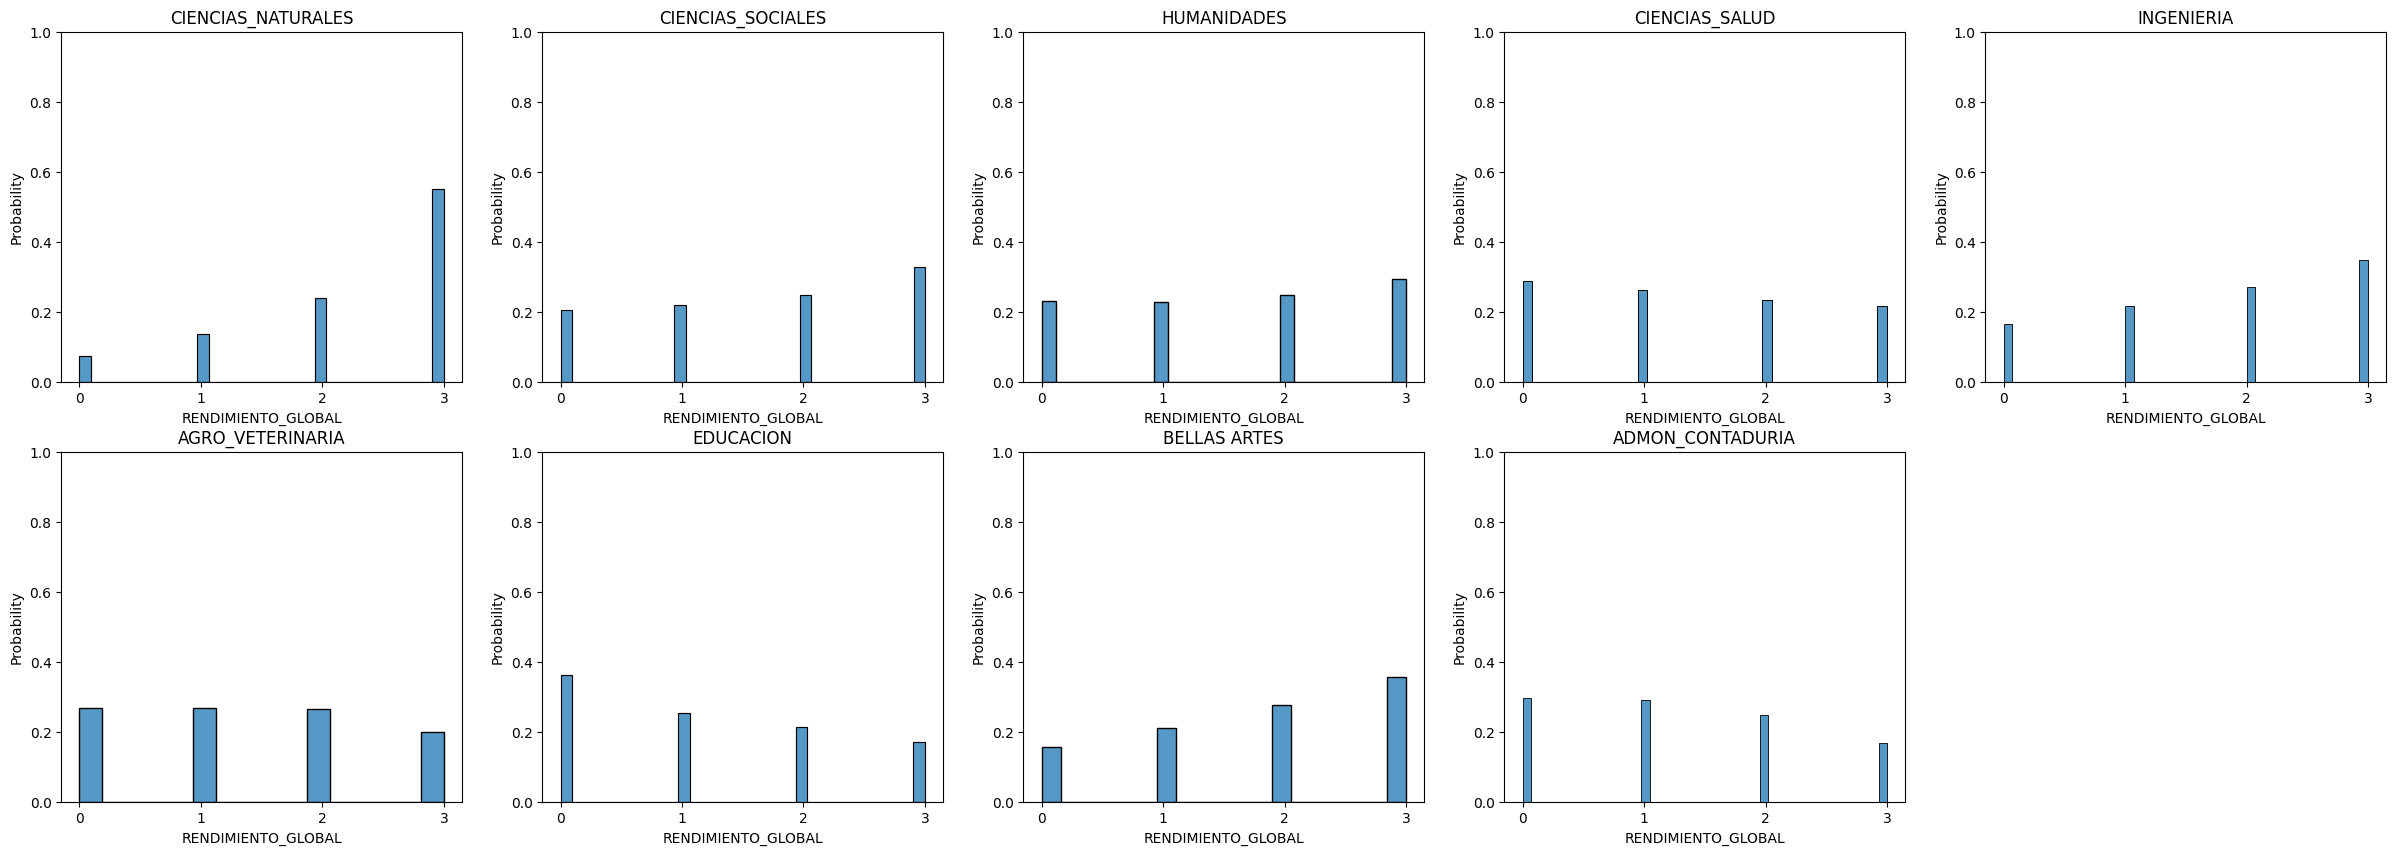

In [ ]:
plt.figure(figsize=(30,10))

knowledge_area = ['CIENCIAS_NATURALES','CIENCIAS_SOCIALES','HUMANIDADES','CIENCIAS_SALUD','INGENIERIA','AGRO_VETERINARIA',
        'EDUCACION','BELLAS ARTES', 'ADMON_CONTADURIA']

grades = ["bajo", "medio-bajo", "medio-alto", "alto"]

for i,c in enumerate(knowledge_area):
    plt.subplot(2,5,i+1)
    k = df_copy[[c,"RENDIMIENTO_GLOBAL"]].dropna()
    sns.histplot(k.RENDIMIENTO_GLOBAL[k[c]==1], stat='probability');
    plt.title(c)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xticks([0,1,2,3])


Se nota que si existen diferencias significativas en los resultadosde las pruebas de acuerdo al área del programa de estudio. Los estudiantes de ciencias naturales tienen una mayor probabilidad de obtener un resultado alto, igualmente para ingeniería y bellas artes, hay tendencia a resultados relativamente mejores que en las otras áreas donde se observan distribuciones casi uniformes o casi que abultadas a la izquierda, es decir, con menor desempeño.

##Definiendo procedimiento de transformación

A continuación se definen funciones auxiliares y una función de procesamiento que aplique cada una de las transformaciones vistas anteriormente y de modo que se pueda aplicar directamente a los diferentes conjuntos de datos, Test o Train. Debemos tener en cuenta que para el conjunto de test no existe columna para la variable respuesta

In [ ]:
## Transformar columnas de si o no
def to_binary(df, columns):

  df_copy = df.copy()

  for col in columns:
    not_null_column =  df_copy.loc[~df_copy[col].isna()]
    not_null_column = ((not_null_column =="Si") | (not_null_column == "S")).astype(int)
    df_copy.loc[~df_copy[col].isna(), col] = not_null_column[col]

  return df_copy

## Transformación rangos categoricos con orden implicito
def define_education_levels():
  education = []
  education.append("Ninguno")
  education.append("Primaria incompleta")
  education.append("Primaria completa")
  education.append("Secundaria (Bachillerato) incompleta")
  education.append("Secundaria (Bachillerato) completa")
  education.append("Técnica o tecnológica incompleta")
  education.append("No Aplica")
  education.append("No sabe")
  education.append("Técnica o tecnológica completa")
  education.append("Educación profesional incompleta")
  education.append("Educación profesional completa")
  education.append("Postgrado")
  return education

def to_ordered_categories(df, column, values):

  df_copy = df.copy()
  keys = [int(i) for i in range(len(values))]
  replacement = dict(zip(values, keys))
  df_copy[column] = df_copy[column].replace(replacement)
  return df_copy

## Transformación one hot
def to_onehot(x):
    values = np.unique(x)
    r = np.r_[[np.argwhere(i==values)[0][0] for i in x]]
    return np.eye(len(values))[r].astype(int)

def replace_columns_with_onehot(d, col):
    k = to_onehot(d[col].values)
    r = pd.DataFrame(k, columns=["%s_%d"%(col, i) for i in range(k.shape[1])], index=d.index).join(d)
    del(r[col])
    return r

def create_dictionary_programs(programs_df):
  programs = {}
  for program, cat in zip(programs_df['PROGRAMA   '], programs_df['CATEGORIA']):
    if cat not in programs.keys():
      programs[cat] = [program]
    else:
      programs[cat].append(program)

  return programs

def add_knowledge_area_cols(df, programs):
  df_copy = df.copy()

  for area in programs.keys():
    column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =[area])
    df_copy = df_copy.join(column)

  return df_copy

def categorize_programs(df, programs):
  df_copy = df.copy()

  def check_program(program, area):
    return program in programs[area]

  check = np.vectorize(check_program)

  for area in programs.keys():
    df_copy[area] = (check(df_copy['ESTU_PRGM_ACADEMICO'], area)).astype(int)

  return df_copy

def fill_nulls(df, columns):

  df_copy = df.copy()
  for col in columns:
    p = []
    n = df_copy[col].dropna().shape[0]
    for val in df_copy[col].dropna().unique():
      p.append(np.sum(df_copy[col]==val)/n)

    total_nulls = df_copy[col].shape[0]-n
    values = np.random.choice(df_copy[col].dropna().unique(),size=total_nulls, p=p)

    df_copy.loc[df_copy[col].isna(),col] = values.astype(int)
    df_copy[col] = df_copy[col].astype(int)

  return df_copy

In [ ]:
def process_data(df):

  try:
    programs_df = pd.read_csv('Categorias.csv', sep=';',encoding='latin-1')
  except:
    print("No se ha cargado el archivo Categorias.csv al entorno")

  df_copy = df.copy()
  # drop ID column - repeated internet
  del(df_copy['ID'])
  df_copy = df_copy.drop(columns=['FAMI_TIENEINTERNET.1'])
  # Cambio a binarias
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL',
           'FAMI_TIENECOMPUTADOR','ESTU_PAGOMATRICULAPROPIO', 'ESTU_PRIVADO_LIBERTAD']

  df_copy = to_binary(df_copy, columns)
  ## Categorias ordenadas
  # Estrato
  values = ["Sin Estrato", "Estrato 1", "Estrato 2", "Estrato 3", "Estrato 4", "Estrato 5", "Estrato 6"]
  df_copy = to_ordered_categories(df_copy, "FAMI_ESTRATOVIVIENDA", values)
  # Educacion padres
  education = define_education_levels()
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONPADRE", education)
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONMADRE", education)
  # horas trabajo
  values = ['0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas']
  df_copy = to_ordered_categories(df_copy,"ESTU_HORASSEMANATRABAJA", values)
  # valor matricula
  values = ['No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón', 'Entre 1 millón y menos de 2.5 millones',
          'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones',
          'Entre 5.5 millones y menos de 7 millones','Más de 7 millones']

  df_copy = to_ordered_categories(df_copy,"ESTU_VALORMATRICULAUNIVERSIDAD", values)
  # periodo
  values = [20183, 20184, 20194, 20195, 20196, 20202, 20203, 20212, 20213]
  df_copy = to_ordered_categories(df_copy,"PERIODO", values)
  # Variable respuesta
  if 'RENDIMIENTO_GLOBAL' in df_copy.columns:
    grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
    df_copy = to_ordered_categories(df_copy,"RENDIMIENTO_GLOBAL", grades)

  # One hot  departamentos
  df_copy = replace_columns_with_onehot(df_copy, 'ESTU_PRGM_DEPARTAMENTO')

  # Areas de conocimiento - clasificación programas
  # creacion diccionario
  programs = create_dictionary_programs(programs_df)
  # creacion columnas
  df_copy = add_knowledge_area_cols(df_copy, programs)
  # categorizacion
  df_copy = categorize_programs(df_copy, programs)
  # Eliminacion columna programas
  df_copy = df_copy.drop(columns=['ESTU_PRGM_ACADEMICO'])

  # Relleno nulos
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','FAMI_TIENECOMPUTADOR',
           'ESTU_PAGOMATRICULAPROPIO','ESTU_PRIVADO_LIBERTAD', 'FAMI_ESTRATOVIVIENDA','FAMI_EDUCACIONPADRE',
           'FAMI_EDUCACIONMADRE', 'ESTU_HORASSEMANATRABAJA','ESTU_VALORMATRICULAUNIVERSIDAD']

  df_copy = fill_nulls(df_copy, columns)

  return df_copy

In [ ]:
df = pd.read_csv("train.csv")
df_processed = process_data(df)
if df_processed is not None:
  df_processed.head()

/tmp/ipython-input-87-2346764430.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


In [ ]:
df_processed.head()

,ESTU_PRGM_DEPARTAMENTO_0,ESTU_PRGM_DEPARTAMENTO_1,ESTU_PRGM_DEPARTAMENTO_2,ESTU_PRGM_DEPARTAMENTO_3,ESTU_PRGM_DEPARTAMENTO_4,ESTU_PRGM_DEPARTAMENTO_5,ESTU_PRGM_DEPARTAMENTO_6,ESTU_PRGM_DEPARTAMENTO_7,ESTU_PRGM_DEPARTAMENTO_8,ESTU_PRGM_DEPARTAMENTO_9,...,coef_4,CIENCIAS_SALUD,CIENCIAS_SOCIALES,ADMON_CONTADURIA,AGRO_VETERINARIA,INGENIERIA,EDUCACION,HUMANIDADES,BELLAS ARTES,CIENCIAS_NATURALES
0,0,0,0,0,1,0,0,0,0,0,...,0.267,1,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0.264,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0.264,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0.190,0,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0.294,1,0,0,0,0,0,0,0,0


In [ ]:
df_processed.shape

(692500, 57)

In [ ]:
for column in df_processed.columns:
    print ("%20s"%column, df_processed[column].dtype)

ESTU_PRGM_DEPARTAMENTO_0 int64
ESTU_PRGM_DEPARTAMENTO_1 int64
ESTU_PRGM_DEPARTAMENTO_2 int64
ESTU_PRGM_DEPARTAMENTO_3 int64
ESTU_PRGM_DEPARTAMENTO_4 int64
ESTU_PRGM_DEPARTAMENTO_5 int64
ESTU_PRGM_DEPARTAMENTO_6 int64
ESTU_PRGM_DEPARTAMENTO_7 int64
ESTU_PRGM_DEPARTAMENTO_8 int64
ESTU_PRGM_DEPARTAMENTO_9 int64
ESTU_PRGM_DEPARTAMENTO_10 int64
ESTU_PRGM_DEPARTAMENTO_11 int64
ESTU_PRGM_DEPARTAMENTO_12 int64
ESTU_PRGM_DEPARTAMENTO_13 int64
ESTU_PRGM_DEPARTAMENTO_14 int64
ESTU_PRGM_DEPARTAMENTO_15 int64
ESTU_PRGM_DEPARTAMENTO_16 int64
ESTU_PRGM_DEPARTAMENTO_17 int64
ESTU_PRGM_DEPARTAMENTO_18 int64
ESTU_PRGM_DEPARTAMENTO_19 int64
ESTU_PRGM_DEPARTAMENTO_20 int64
ESTU_PRGM_DEPARTAMENTO_21 int64
ESTU_PRGM_DEPARTAMENTO_22 int64
ESTU_PRGM_DEPARTAMENTO_23 int64
ESTU_PRGM_DEPARTAMENTO_24 int64
ESTU_PRGM_DEPARTAMENTO_25 int64
ESTU_PRGM_DEPARTAMENTO_26 int64
ESTU_PRGM_DEPARTAMENTO_27 int64
ESTU_PRGM_DEPARTAMENTO_28 int64
ESTU_PRGM_DEPARTAMENTO_29 int64
ESTU_PRGM_DEPARTAMENTO_30 int64
             PERIO

In [ ]:
df_processed['ESTU_VALORMATRICULAUNIVERSIDAD'].head(20)

,ESTU_VALORMATRICULAUNIVERSIDAD
0,6
1,4
2,4
3,5
4,4
5,7
6,4
7,3
8,6
9,4


##Otro posible enfoque de procesamiento

A pesar de que se ha demostrado una cierta correlación entre el programa, aplicaremos una optica de preprocesamiento en el que se ignore dicha información para luego ser evaluada con los diferentes modelos experimentados

###Definiendo función de preprocesado

In [ ]:
## Transformar columnas de si o no
def to_binary(df, columns):

  df_copy = df.copy()

  for col in columns:
    not_null_column =  df_copy.loc[~df_copy[col].isna()]
    not_null_column = ((not_null_column =="Si") | (not_null_column == "S")).astype(int)
    df_copy.loc[~df_copy[col].isna(), col] = not_null_column[col]

  return df_copy

## Transformación rangos categoricos con orden implicito
def define_education_levels():
  education = []
  education.append("Ninguno")
  education.append("Primaria incompleta")
  education.append("Primaria completa")
  education.append("Secundaria (Bachillerato) incompleta")
  education.append("Secundaria (Bachillerato) completa")
  education.append("Técnica o tecnológica incompleta")
  education.append("No Aplica")
  education.append("No sabe")
  education.append("Técnica o tecnológica completa")
  education.append("Educación profesional incompleta")
  education.append("Educación profesional completa")
  education.append("Postgrado")
  return education

def to_ordered_categories(df, column, values):

  df_copy = df.copy()
  keys = [int(i) for i in range(len(values))]
  replacement = dict(zip(values, keys))
  df_copy[column] = df_copy[column].replace(replacement)
  return df_copy

## Transformación one hot
def to_onehot(x):
    values = np.unique(x)
    r = np.r_[[np.argwhere(i==values)[0][0] for i in x]]
    return np.eye(len(values))[r].astype(int)

def replace_columns_with_onehot(d, col):
    k = to_onehot(d[col].values)
    r = pd.DataFrame(k, columns=["%s_%d"%(col, i) for i in range(k.shape[1])], index=d.index).join(d)
    del(r[col])
    return r

def fill_nulls(df, columns):

  df_copy = df.copy()
  for col in columns:
    p = []
    n = df_copy[col].dropna().shape[0]
    for val in df_copy[col].dropna().unique():
      p.append(np.sum(df_copy[col]==val)/n)

    total_nulls = df_copy[col].shape[0]-n
    values = np.random.choice(df_copy[col].dropna().unique(),size=total_nulls, p=p)

    df_copy.loc[df_copy[col].isna(),col] = values.astype(int)
    df_copy[col] = df_copy[col].astype(int)

  return df_copy

In [ ]:
def process_data(df):

  try:
    programs_df = pd.read_csv('Categorias.csv', sep=';',encoding='latin-1')
  except:
    print("No se ha cargado el archivo Categorias.csv al entorno")

  df_copy = df.copy()
  # drop ID column - repeated internet - programa
  del(df_copy['ID'])
  df_copy = df_copy.drop(columns=['FAMI_TIENEINTERNET.1'])
  df_copy = df_copy.drop(columns=['ESTU_PRGM_ACADEMICO'])
  # Cambio a binarias
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL',
           'FAMI_TIENECOMPUTADOR','ESTU_PAGOMATRICULAPROPIO', 'ESTU_PRIVADO_LIBERTAD']

  df_copy = to_binary(df_copy, columns)
  ## Categorias ordenadas
  # Estrato
  values = ["Sin Estrato", "Estrato 1", "Estrato 2", "Estrato 3", "Estrato 4", "Estrato 5", "Estrato 6"]
  df_copy = to_ordered_categories(df_copy, "FAMI_ESTRATOVIVIENDA", values)
  # Educacion padres
  education = define_education_levels()
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONPADRE", education)
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONMADRE", education)
  # horas trabajo
  values = ['0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas']
  df_copy = to_ordered_categories(df_copy,"ESTU_HORASSEMANATRABAJA", values)
  # valor matricula
  values = ['No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón', 'Entre 1 millón y menos de 2.5 millones',
          'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones',
          'Entre 5.5 millones y menos de 7 millones','Más de 7 millones']

  df_copy = to_ordered_categories(df_copy,"ESTU_VALORMATRICULAUNIVERSIDAD", values)
  # periodo
  values = [20183, 20184, 20194, 20195, 20196, 20202, 20203, 20212, 20213]
  df_copy = to_ordered_categories(df_copy,"PERIODO", values)
  # Variable respuesta
  if 'RENDIMIENTO_GLOBAL' in df_copy.columns:
    grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
    df_copy = to_ordered_categories(df_copy,"RENDIMIENTO_GLOBAL", grades)

  # One hot  departamentos
  df_copy = replace_columns_with_onehot(df_copy, 'ESTU_PRGM_DEPARTAMENTO')

  # Relleno nulos
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','FAMI_TIENECOMPUTADOR',
           'ESTU_PAGOMATRICULAPROPIO','ESTU_PRIVADO_LIBERTAD', 'FAMI_ESTRATOVIVIENDA','FAMI_EDUCACIONPADRE',
           'FAMI_EDUCACIONMADRE', 'ESTU_HORASSEMANATRABAJA','ESTU_VALORMATRICULAUNIVERSIDAD']

  df_copy = fill_nulls(df_copy, columns)

  return df_copy

In [ ]:
df = pd.read_csv("train.csv")
df_processed = process_data(df)
if df_processed is not None:
  df_processed.head()

/tmp/ipython-input-82-2512553109.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


In [ ]:
print(df_processed.shape)
df_processed.head()

(692500, 48)


,ESTU_PRGM_DEPARTAMENTO_0,ESTU_PRGM_DEPARTAMENTO_1,ESTU_PRGM_DEPARTAMENTO_2,ESTU_PRGM_DEPARTAMENTO_3,ESTU_PRGM_DEPARTAMENTO_4,ESTU_PRGM_DEPARTAMENTO_5,ESTU_PRGM_DEPARTAMENTO_6,ESTU_PRGM_DEPARTAMENTO_7,ESTU_PRGM_DEPARTAMENTO_8,ESTU_PRGM_DEPARTAMENTO_9,...,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,coef_1,coef_2,coef_3,coef_4
0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,11,2,0.322,0.208,0.310,0.267
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,5,0,0.311,0.215,0.292,0.264
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,4,0,0.297,0.214,0.305,0.264
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,4,3,0.485,0.172,0.252,0.190
4,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,2,1,0.316,0.232,0.285,0.294


In [ ]:
for column in df_processed.columns:
    print ("%20s"%column, df_processed[column].dtype)

ESTU_PRGM_DEPARTAMENTO_0 int64
ESTU_PRGM_DEPARTAMENTO_1 int64
ESTU_PRGM_DEPARTAMENTO_2 int64
ESTU_PRGM_DEPARTAMENTO_3 int64
ESTU_PRGM_DEPARTAMENTO_4 int64
ESTU_PRGM_DEPARTAMENTO_5 int64
ESTU_PRGM_DEPARTAMENTO_6 int64
ESTU_PRGM_DEPARTAMENTO_7 int64
ESTU_PRGM_DEPARTAMENTO_8 int64
ESTU_PRGM_DEPARTAMENTO_9 int64
ESTU_PRGM_DEPARTAMENTO_10 int64
ESTU_PRGM_DEPARTAMENTO_11 int64
ESTU_PRGM_DEPARTAMENTO_12 int64
ESTU_PRGM_DEPARTAMENTO_13 int64
ESTU_PRGM_DEPARTAMENTO_14 int64
ESTU_PRGM_DEPARTAMENTO_15 int64
ESTU_PRGM_DEPARTAMENTO_16 int64
ESTU_PRGM_DEPARTAMENTO_17 int64
ESTU_PRGM_DEPARTAMENTO_18 int64
ESTU_PRGM_DEPARTAMENTO_19 int64
ESTU_PRGM_DEPARTAMENTO_20 int64
ESTU_PRGM_DEPARTAMENTO_21 int64
ESTU_PRGM_DEPARTAMENTO_22 int64
ESTU_PRGM_DEPARTAMENTO_23 int64
ESTU_PRGM_DEPARTAMENTO_24 int64
ESTU_PRGM_DEPARTAMENTO_25 int64
ESTU_PRGM_DEPARTAMENTO_26 int64
ESTU_PRGM_DEPARTAMENTO_27 int64
ESTU_PRGM_DEPARTAMENTO_28 int64
ESTU_PRGM_DEPARTAMENTO_29 int64
ESTU_PRGM_DEPARTAMENTO_30 int64
             PERIO

##Correcciones a la categorización de programas

Una situación que no se ha estudiado es la posibilidad y siempre muy común en los problemas de machine learning de encontrar nuevas categorias para ciertas columnas. La categorización de los programas por área de conocimiento debe entonces proveer la posibilidad de adicionar una categoría de otro para estos casos, adicionalmente, como se han clasificado la totalidad de los programas del conjunto de entrenamiento, se añade un muestreo inicial de esta categorización de modo que existan asociaciones "no vistas" y por lo tanto se clasifiquen como Otra area de conocimiento (o desconocida). Adicionalmente se conserva la columna de programa académico por si se desean hacer otros preprocesamientos con esta, como labeling o target encoding

In [ ]:
df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

null_registers = np.sum(test_df['ESTU_PRGM_ACADEMICO'].isna())
print(f"Existen {null_registers} registros nulos en el data set de test para el programa académico")
test_df['ESTU_PRGM_ACADEMICO'].describe()


Existen 0 registros nulos en el data set de test para el programa académico


,ESTU_PRGM_ACADEMICO
count,296786
unique,919
top,DERECHO
freq,22984


In [ ]:
uncategorized_program = []
for program in test_df['ESTU_PRGM_ACADEMICO'].unique():
  if program not in df['ESTU_PRGM_ACADEMICO'].unique():
    uncategorized_program.append(program)

print(f"Existen {len(uncategorized_program)} programas no categorizados en el conjunto de entrenamiento:")
for program in uncategorized_program:
  print(program)

Existen 10 programas no categorizados en el conjunto de entrenamiento:
LICENCIATURA EN EDUCACION ENFASIS EN HUMANIDADES
LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN IDIOMAS EXTRANJEROS
COMUNICACIÖN SOCIAL
NEGOCIOS INTERNACIONALES BILINGUE
LICENCIATURA EN MATEMATICA E INFORMATICA
ADMINISTRACION  DE EMPRESAS.
LICENC.EN EDUCACION BASICA PRIMARIA ENF.EN CIENCIAS NATURALESEDUC.AMBIENTAL MATEMA.LENGUA CASTELLANA
ADMINISTRACION DE EMPRESAS.
ARTE DRAMÁTICO
AGROINDUSTRIA


###Redefinición del procesado

In [ ]:
## Transformar columnas de si o no
def to_binary(df, columns):

  df_copy = df.copy()

  for col in columns:
    not_null_column =  df_copy.loc[~df_copy[col].isna()]
    not_null_column = ((not_null_column =="Si") | (not_null_column == "S")).astype(int)
    df_copy.loc[~df_copy[col].isna(), col] = not_null_column[col]

  return df_copy

## Transformación rangos categoricos con orden implicito
def define_education_levels():
  education = []
  education.append("Ninguno")
  education.append("Primaria incompleta")
  education.append("Primaria completa")
  education.append("Secundaria (Bachillerato) incompleta")
  education.append("Secundaria (Bachillerato) completa")
  education.append("Técnica o tecnológica incompleta")
  education.append("No Aplica")
  education.append("No sabe")
  education.append("Técnica o tecnológica completa")
  education.append("Educación profesional incompleta")
  education.append("Educación profesional completa")
  education.append("Postgrado")
  return education

def to_ordered_categories(df, column, values):

  df_copy = df.copy()
  keys = [int(i) for i in range(len(values))]
  replacement = dict(zip(values, keys))
  df_copy[column] = df_copy[column].replace(replacement)
  return df_copy

## Transformación one hot
def to_onehot(x):
    values = np.unique(x)
    r = np.r_[[np.argwhere(i==values)[0][0] for i in x]]
    return np.eye(len(values))[r].astype(int)

def replace_columns_with_onehot(d, col):
    k = to_onehot(d[col].values)
    r = pd.DataFrame(k, columns=["%s_%d"%(col, i) for i in range(k.shape[1])], index=d.index).join(d)
    del(r[col])
    return r

def create_dictionary_programs(programs_df):
  programs = {}
  for program, cat in zip(programs_df['PROGRAMA   '], programs_df['CATEGORIA']):
    if cat not in programs.keys():
      programs[cat] = [program]
    else:
      programs[cat].append(program)

  return programs

def add_knowledge_area_cols(df, programs):
  df_copy = df.copy()

  for area in programs.keys():
    column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =[area])
    df_copy = df_copy.join(column)

  other_column = pd.DataFrame(np.zeros(df_copy.shape[0]).astype(int), columns =['OTRO'])
  df_copy = df_copy.join(other_column)

  return df_copy

def categorize_programs(df, programs):
  df_copy = df.copy()

  def assign_area(program):
    for area in programs.keys():
      if program in programs[area]:
        return area

    return 'OTRO'

  df_copy['AREA_TMP'] = df_copy['ESTU_PRGM_ACADEMICO'].apply(assign_area)

  for area in programs.keys():
      df_copy[area] = (df_copy['AREA_TMP'] == area).astype(int)

  df_copy['OTRO'] = (df_copy['AREA_TMP'] == 'OTRO').astype(int)
  df_copy = df_copy.drop(columns=['AREA_TMP'])

  return df_copy

def fill_nulls(df, columns):

  df_copy = df.copy()
  for col in columns:
    p = []
    n = df_copy[col].dropna().shape[0]
    for val in df_copy[col].dropna().unique():
      p.append(np.sum(df_copy[col]==val)/n)

    total_nulls = df_copy[col].shape[0]-n
    values = np.random.choice(df_copy[col].dropna().unique(),size=total_nulls, p=p)

    df_copy.loc[df_copy[col].isna(),col] = values.astype(int)
    df_copy[col] = df_copy[col].astype(int)

  return df_copy


In [ ]:
def process_data(df, programs_df):

  df_copy = df.copy()
  # drop ID column - repeated internet
  del(df_copy['ID'])
  df_copy = df_copy.drop(columns=['FAMI_TIENEINTERNET.1'])
  # Cambio a binarias
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL',
           'FAMI_TIENECOMPUTADOR','ESTU_PAGOMATRICULAPROPIO', 'ESTU_PRIVADO_LIBERTAD']

  df_copy = to_binary(df_copy, columns)
  ## Categorias ordenadas
  # Estrato
  values = ["Sin Estrato", "Estrato 1", "Estrato 2", "Estrato 3", "Estrato 4", "Estrato 5", "Estrato 6"]
  df_copy = to_ordered_categories(df_copy, "FAMI_ESTRATOVIVIENDA", values)
  # Educacion padres
  education = define_education_levels()
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONPADRE", education)
  df_copy = to_ordered_categories(df_copy, "FAMI_EDUCACIONMADRE", education)
  # horas trabajo
  values = ['0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas']
  df_copy = to_ordered_categories(df_copy,"ESTU_HORASSEMANATRABAJA", values)
  # valor matricula
  values = ['No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón', 'Entre 1 millón y menos de 2.5 millones',
          'Entre 2.5 millones y menos de 4 millones', 'Entre 4 millones y menos de 5.5 millones',
          'Entre 5.5 millones y menos de 7 millones','Más de 7 millones']

  df_copy = to_ordered_categories(df_copy,"ESTU_VALORMATRICULAUNIVERSIDAD", values)
  # periodo
  values = [20183, 20184, 20194, 20195, 20196, 20202, 20203, 20212, 20213]
  df_copy = to_ordered_categories(df_copy,"PERIODO", values)
  # Variable respuesta
  if 'RENDIMIENTO_GLOBAL' in df_copy.columns:
    grades = ["bajo", "medio-bajo", "medio-alto", "alto"]
    df_copy = to_ordered_categories(df_copy,"RENDIMIENTO_GLOBAL", grades)

  # One hot  departamentos
  df_copy = replace_columns_with_onehot(df_copy, 'ESTU_PRGM_DEPARTAMENTO')

  # Areas de conocimiento - clasificación programas
  # creacion diccionario
  programs = create_dictionary_programs(programs_df)
  # creacion columnas
  df_copy = add_knowledge_area_cols(df_copy, programs)
  # categorizacion
  df_copy = categorize_programs(df_copy, programs)

  # Relleno nulos
  columns = ['FAMI_TIENEINTERNET','FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','FAMI_TIENECOMPUTADOR',
           'ESTU_PAGOMATRICULAPROPIO','ESTU_PRIVADO_LIBERTAD', 'FAMI_ESTRATOVIVIENDA','FAMI_EDUCACIONPADRE',
           'FAMI_EDUCACIONMADRE', 'ESTU_HORASSEMANATRABAJA','ESTU_VALORMATRICULAUNIVERSIDAD']

  df_copy = fill_nulls(df_copy, columns)

  return df_copy

####Muestreo inicial de la categorización de los programas

In [ ]:
programs_df = pd.read_csv('Categorias.csv', sep=';',encoding='latin-1')
programs_df = programs_df.sample(frac=0.70, random_state=42)

####Procesado

In [ ]:
df_processed = process_data(df, programs_df)
df_processed.head()

/tmp/ipython-input-97-124035498.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


,ESTU_PRGM_DEPARTAMENTO_0,ESTU_PRGM_DEPARTAMENTO_1,ESTU_PRGM_DEPARTAMENTO_2,ESTU_PRGM_DEPARTAMENTO_3,ESTU_PRGM_DEPARTAMENTO_4,ESTU_PRGM_DEPARTAMENTO_5,ESTU_PRGM_DEPARTAMENTO_6,ESTU_PRGM_DEPARTAMENTO_7,ESTU_PRGM_DEPARTAMENTO_8,ESTU_PRGM_DEPARTAMENTO_9,...,CIENCIAS_NATURALES,EDUCACION,INGENIERIA,HUMANIDADES,ADMON_CONTADURIA,CIENCIAS_SOCIALES,BELLAS ARTES,CIENCIAS_SALUD,AGRO_VETERINARIA,OTRO
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
test_df_processed = process_data(test_df, programs_df)
test_df_processed.head()

/tmp/ipython-input-97-124035498.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[column] = df_copy[column].replace(replacement)


,ESTU_PRGM_DEPARTAMENTO_0,ESTU_PRGM_DEPARTAMENTO_1,ESTU_PRGM_DEPARTAMENTO_2,ESTU_PRGM_DEPARTAMENTO_3,ESTU_PRGM_DEPARTAMENTO_4,ESTU_PRGM_DEPARTAMENTO_5,ESTU_PRGM_DEPARTAMENTO_6,ESTU_PRGM_DEPARTAMENTO_7,ESTU_PRGM_DEPARTAMENTO_8,ESTU_PRGM_DEPARTAMENTO_9,...,CIENCIAS_NATURALES,EDUCACION,INGENIERIA,HUMANIDADES,ADMON_CONTADURIA,CIENCIAS_SOCIALES,BELLAS ARTES,CIENCIAS_SALUD,AGRO_VETERINARIA,OTRO
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
